In [1]:
import pandas as pd
import numpy as np
import nltk
import pickle
import pyLDAvis.sklearn
from collections import Counter
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.decomposition import LatentDirichletAllocation, NMF
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_pickle("./data_cleaned.pkl")

In [3]:
data.columns

Index(['title', 'flair', 'no_contract', 'title_description', 'tokenized',
       'lower', 'stopwords_removed', 'pos_tags', 'wordnet_pos', 'lemmatized',
       'small_words_rem'],
      dtype='object')

In [4]:
data = data[['flair', 'small_words_rem']]
data

,flair,small_words_rem
0,Business/Finance,"[allow, bank, hold, passport, loan, taker, mad..."
1,Policy/Economy,"[tamil, nadu, usher, new, year, green, note, b..."
2,Policy/Economy,"[bad, npa, crisis, say, rbi, report]"
3,Sports,"[ravi, shastri, comment, keefe, kerry, keefe, ..."
4,Photography,"[picture, click, pillar, rock, kodaikanal, rec..."
...,...,...
20743,Coronavirus,"[india, leave, behind, local, transmission, ph..."
20744,Policy/Economy,"[side, story, small, businessman]"
20745,Coronavirus,"[indian, astronaut, train, hold, russia, due, ..."
20746,Coronavirus,"[covid, government, threaten, kashmir, doctor,..."


In [5]:
data['small_words_rem_str'] = [" ".join(map(str, l)) for l in data['small_words_rem']]
data

,flair,small_words_rem,small_words_rem_str
0,Business/Finance,"[allow, bank, hold, passport, loan, taker, mad...",allow bank hold passport loan taker madras sug...
1,Policy/Economy,"[tamil, nadu, usher, new, year, green, note, b...",tamil nadu usher new year green note ban singl...
2,Policy/Economy,"[bad, npa, crisis, say, rbi, report]",bad npa crisis say rbi report
3,Sports,"[ravi, shastri, comment, keefe, kerry, keefe, ...",ravi shastri comment keefe kerry keefe joke ma...
4,Photography,"[picture, click, pillar, rock, kodaikanal, rec...",picture click pillar rock kodaikanal recent tr...
...,...,...,...
20743,Coronavirus,"[india, leave, behind, local, transmission, ph...",india leave behind local transmission phase mo...
20744,Policy/Economy,"[side, story, small, businessman]",side story small businessman
20745,Coronavirus,"[indian, astronaut, train, hold, russia, due, ...",indian astronaut train hold russia due covid l...
20746,Coronavirus,"[covid, government, threaten, kashmir, doctor,...",covid government threaten kashmir doctor stric...


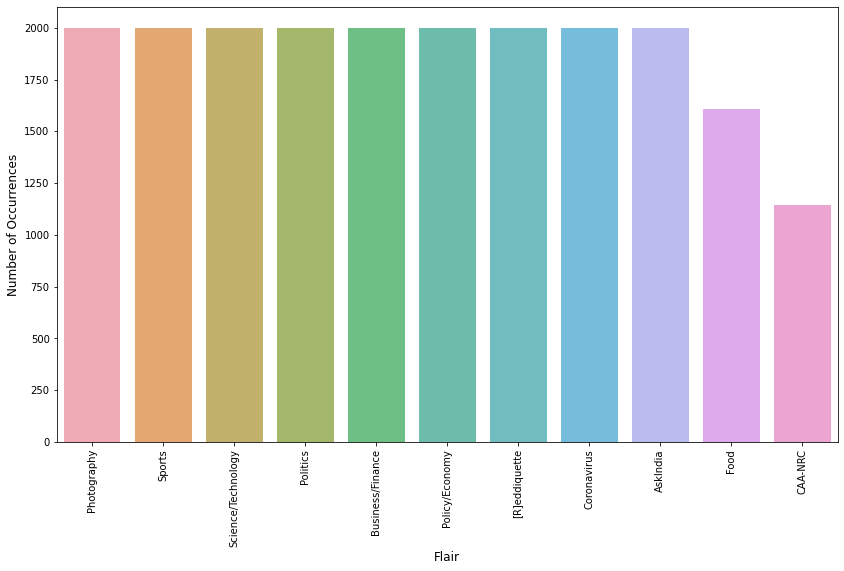

In [6]:
flair_hist = data['flair'].value_counts()
plt.figure(figsize=(14,8))
sns.barplot(flair_hist.index, flair_hist.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Flair', fontsize=12)
plt.xticks(rotation=90)
plt.show()

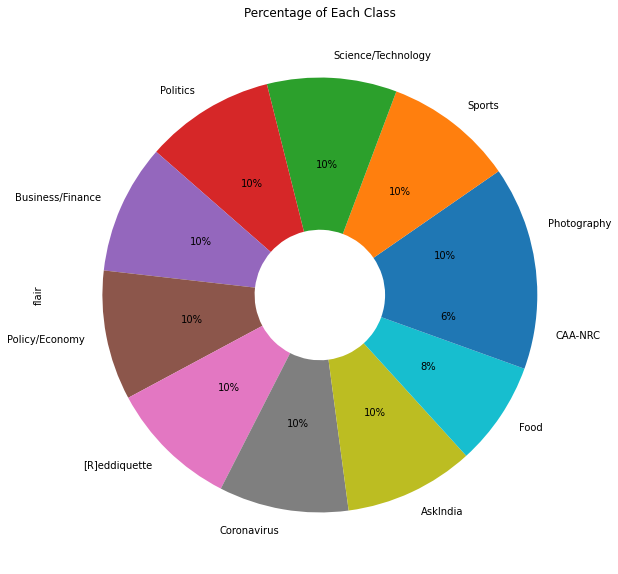

In [7]:
plt.figure(figsize=(30,10))
plt.title("Percentage of Each Class")
flair_hist.plot(kind='pie', labels=flair_hist.index, wedgeprops=dict(width=.7), autopct='%1.0f%%')

Creating two additional features of “word_count” to determine the number of words per review and “post_len” to determine the number of letters per review.

In [8]:
data['post_len'] = data['small_words_rem'].astype(str).apply(len)
data['word_count'] = data['small_words_rem'].apply(lambda x: len(str(x).split()))
data

,flair,small_words_rem,small_words_rem_str,post_len,word_count
0,Business/Finance,"[allow, bank, hold, passport, loan, taker, mad...",allow bank hold passport loan taker madras sug...,76,8
1,Policy/Economy,"[tamil, nadu, usher, new, year, green, note, b...",tamil nadu usher new year green note ban singl...,93,11
2,Policy/Economy,"[bad, npa, crisis, say, rbi, report]",bad npa crisis say rbi report,48,6
3,Sports,"[ravi, shastri, comment, keefe, kerry, keefe, ...",ravi shastri comment keefe kerry keefe joke ma...,825,84
4,Photography,"[picture, click, pillar, rock, kodaikanal, rec...",picture click pillar rock kodaikanal recent tr...,201,21
...,...,...,...,...,...
20743,Coronavirus,"[india, leave, behind, local, transmission, ph...",india leave behind local transmission phase mo...,130,12
20744,Policy/Economy,"[side, story, small, businessman]",side story small businessman,41,4
20745,Coronavirus,"[indian, astronaut, train, hold, russia, due, ...",indian astronaut train hold russia due covid l...,78,8
20746,Coronavirus,"[covid, government, threaten, kashmir, doctor,...",covid government threaten kashmir doctor stric...,94,9


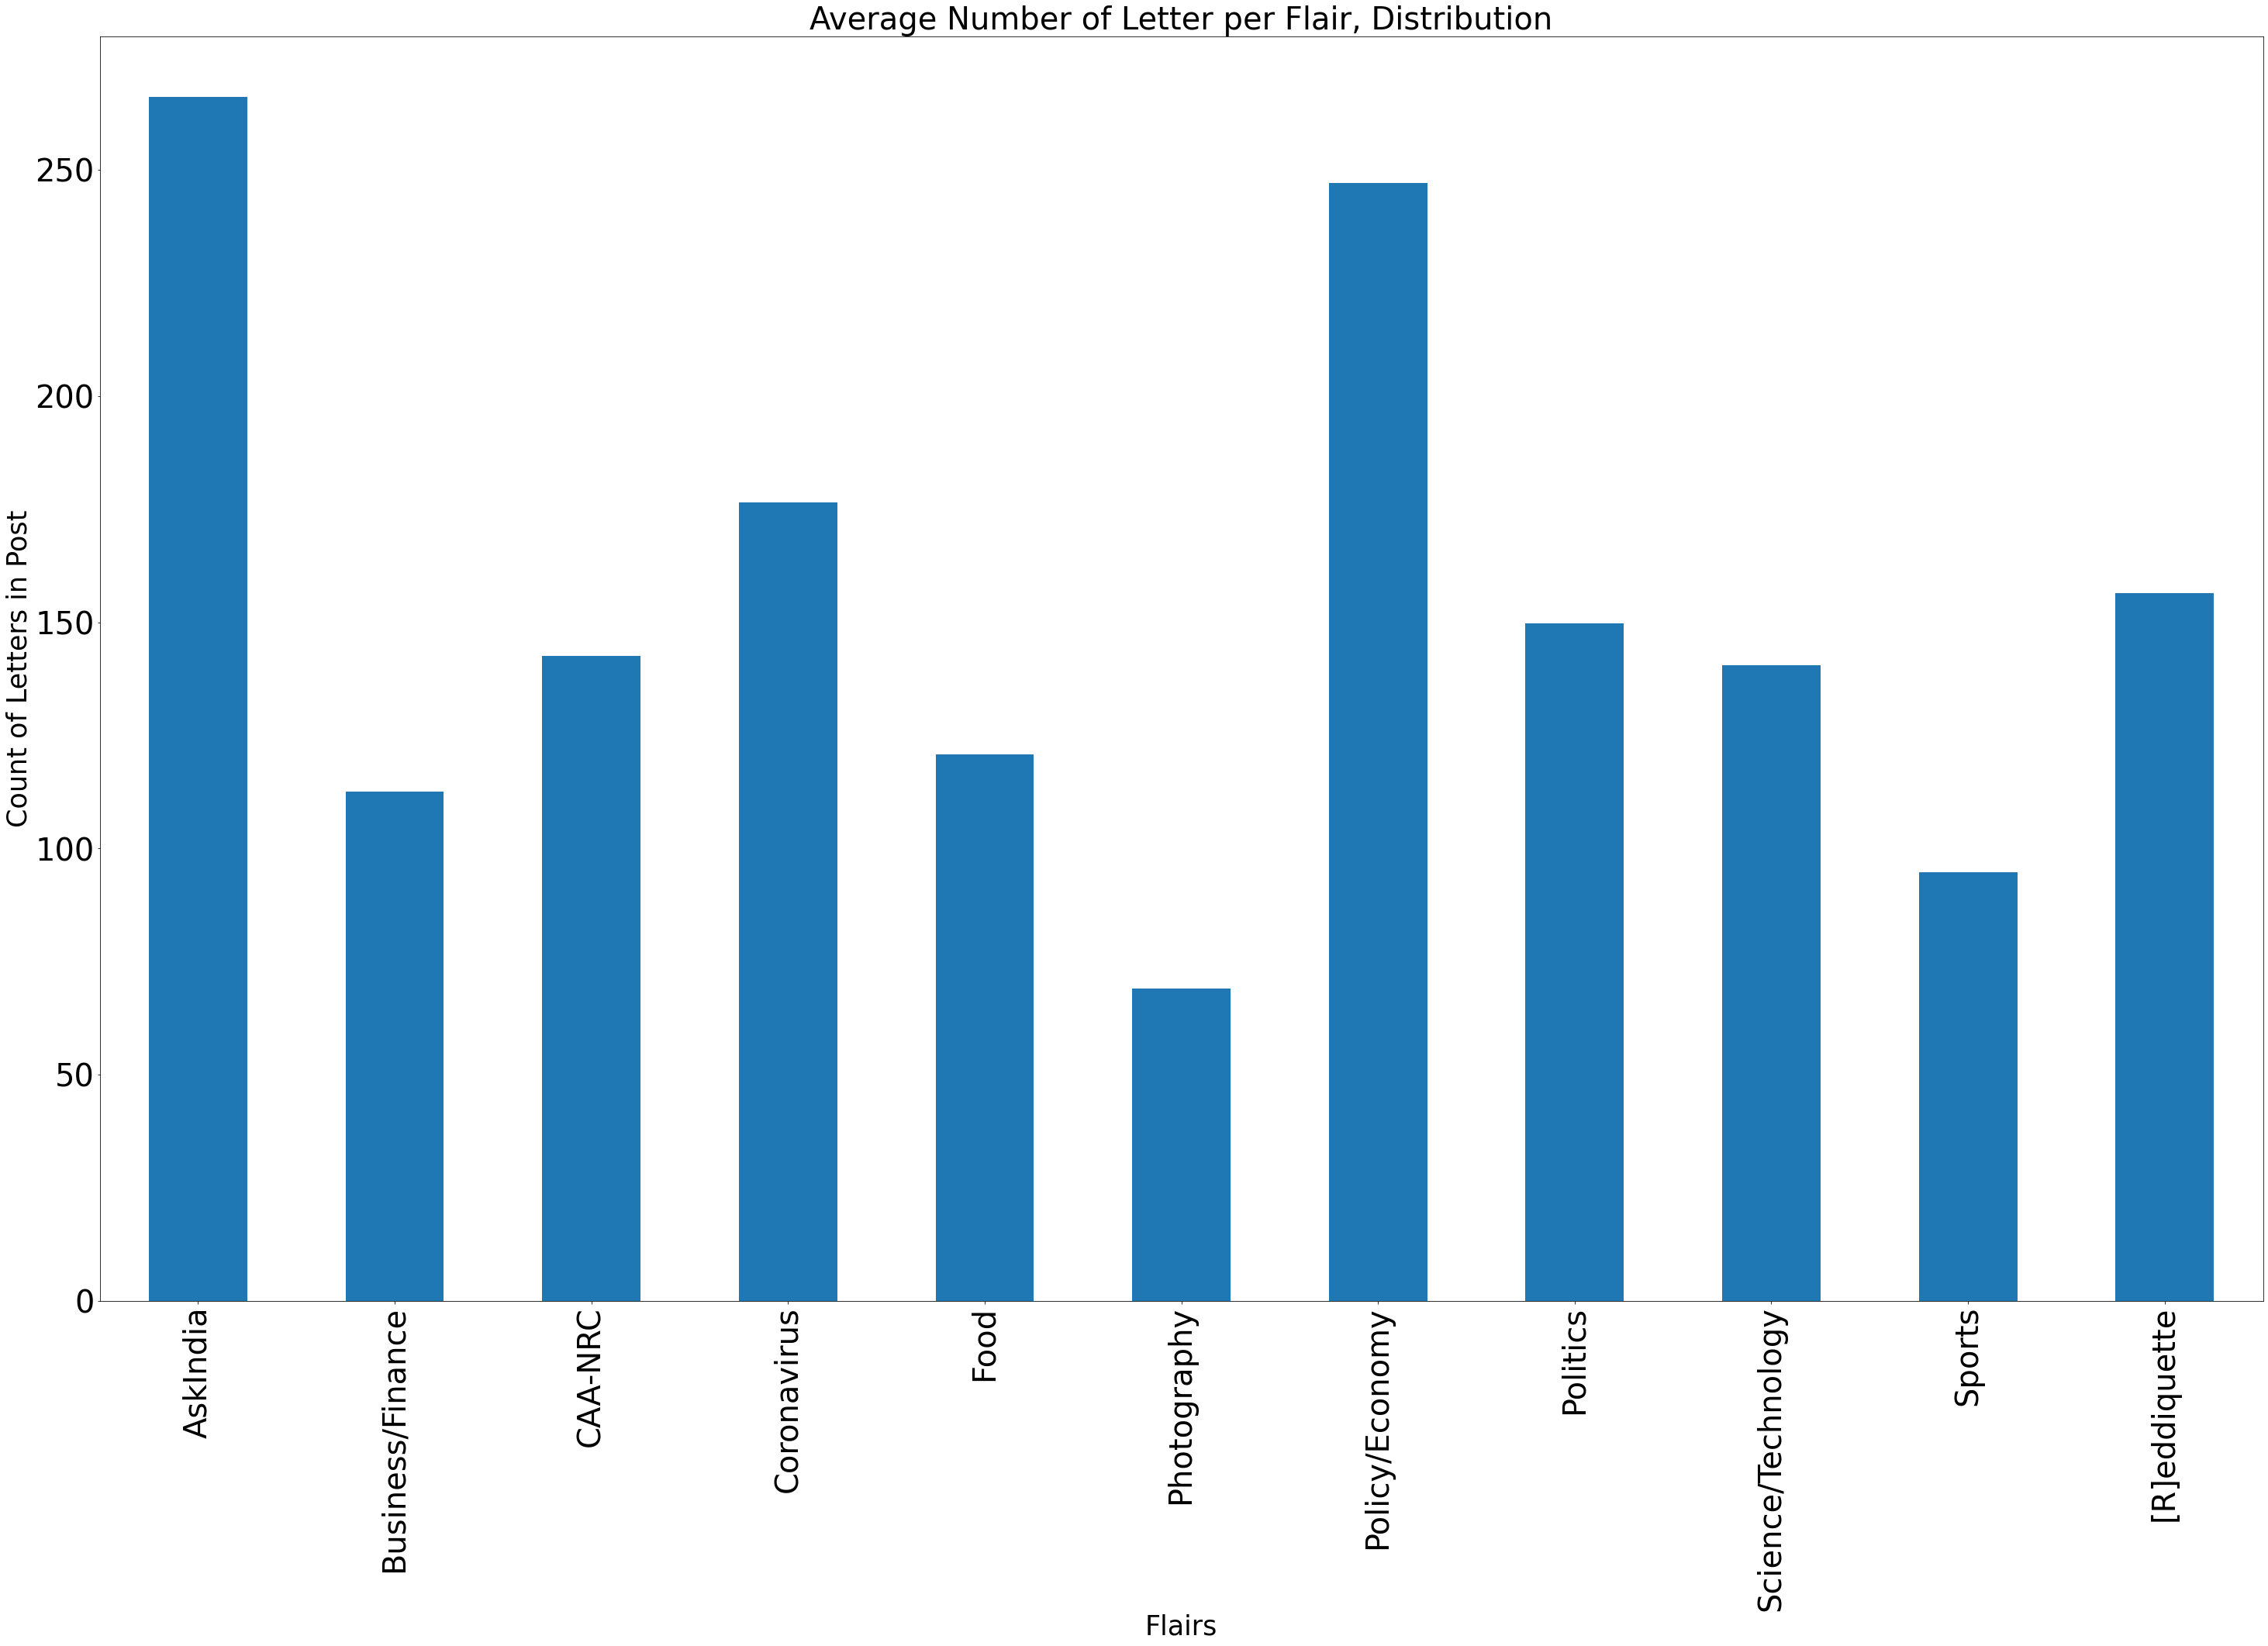

In [9]:
letter_avg = data.groupby('flair')['post_len'].mean().plot(kind='bar', figsize = (50, 30))
plt.xlabel('Flairs', fontsize= 35)
plt.ylabel('Count of Letters in Post', fontsize = 35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title("Average Number of Letter per Flair, Distribution", fontsize= 40)
plt.show()

The posts pertating to "AskIndia" and "Policy/Economy" are very descriptive compared to the posts of other flair classes. Although it's not surprising that AskIndia has the highest average post length, we can infer that posts belonging to "AskIndia" are very descriptive and detailed, similar to how a question is asked, by providing sufficient information.

Also, For "Photography" class we can infer that the post are succint descriptions about a photograph posted or photography in general. 

## Term Frequency Analysis

In [10]:
words = data['small_words_rem']
allwords = []

for wordlist in words:
    allwords += wordlist

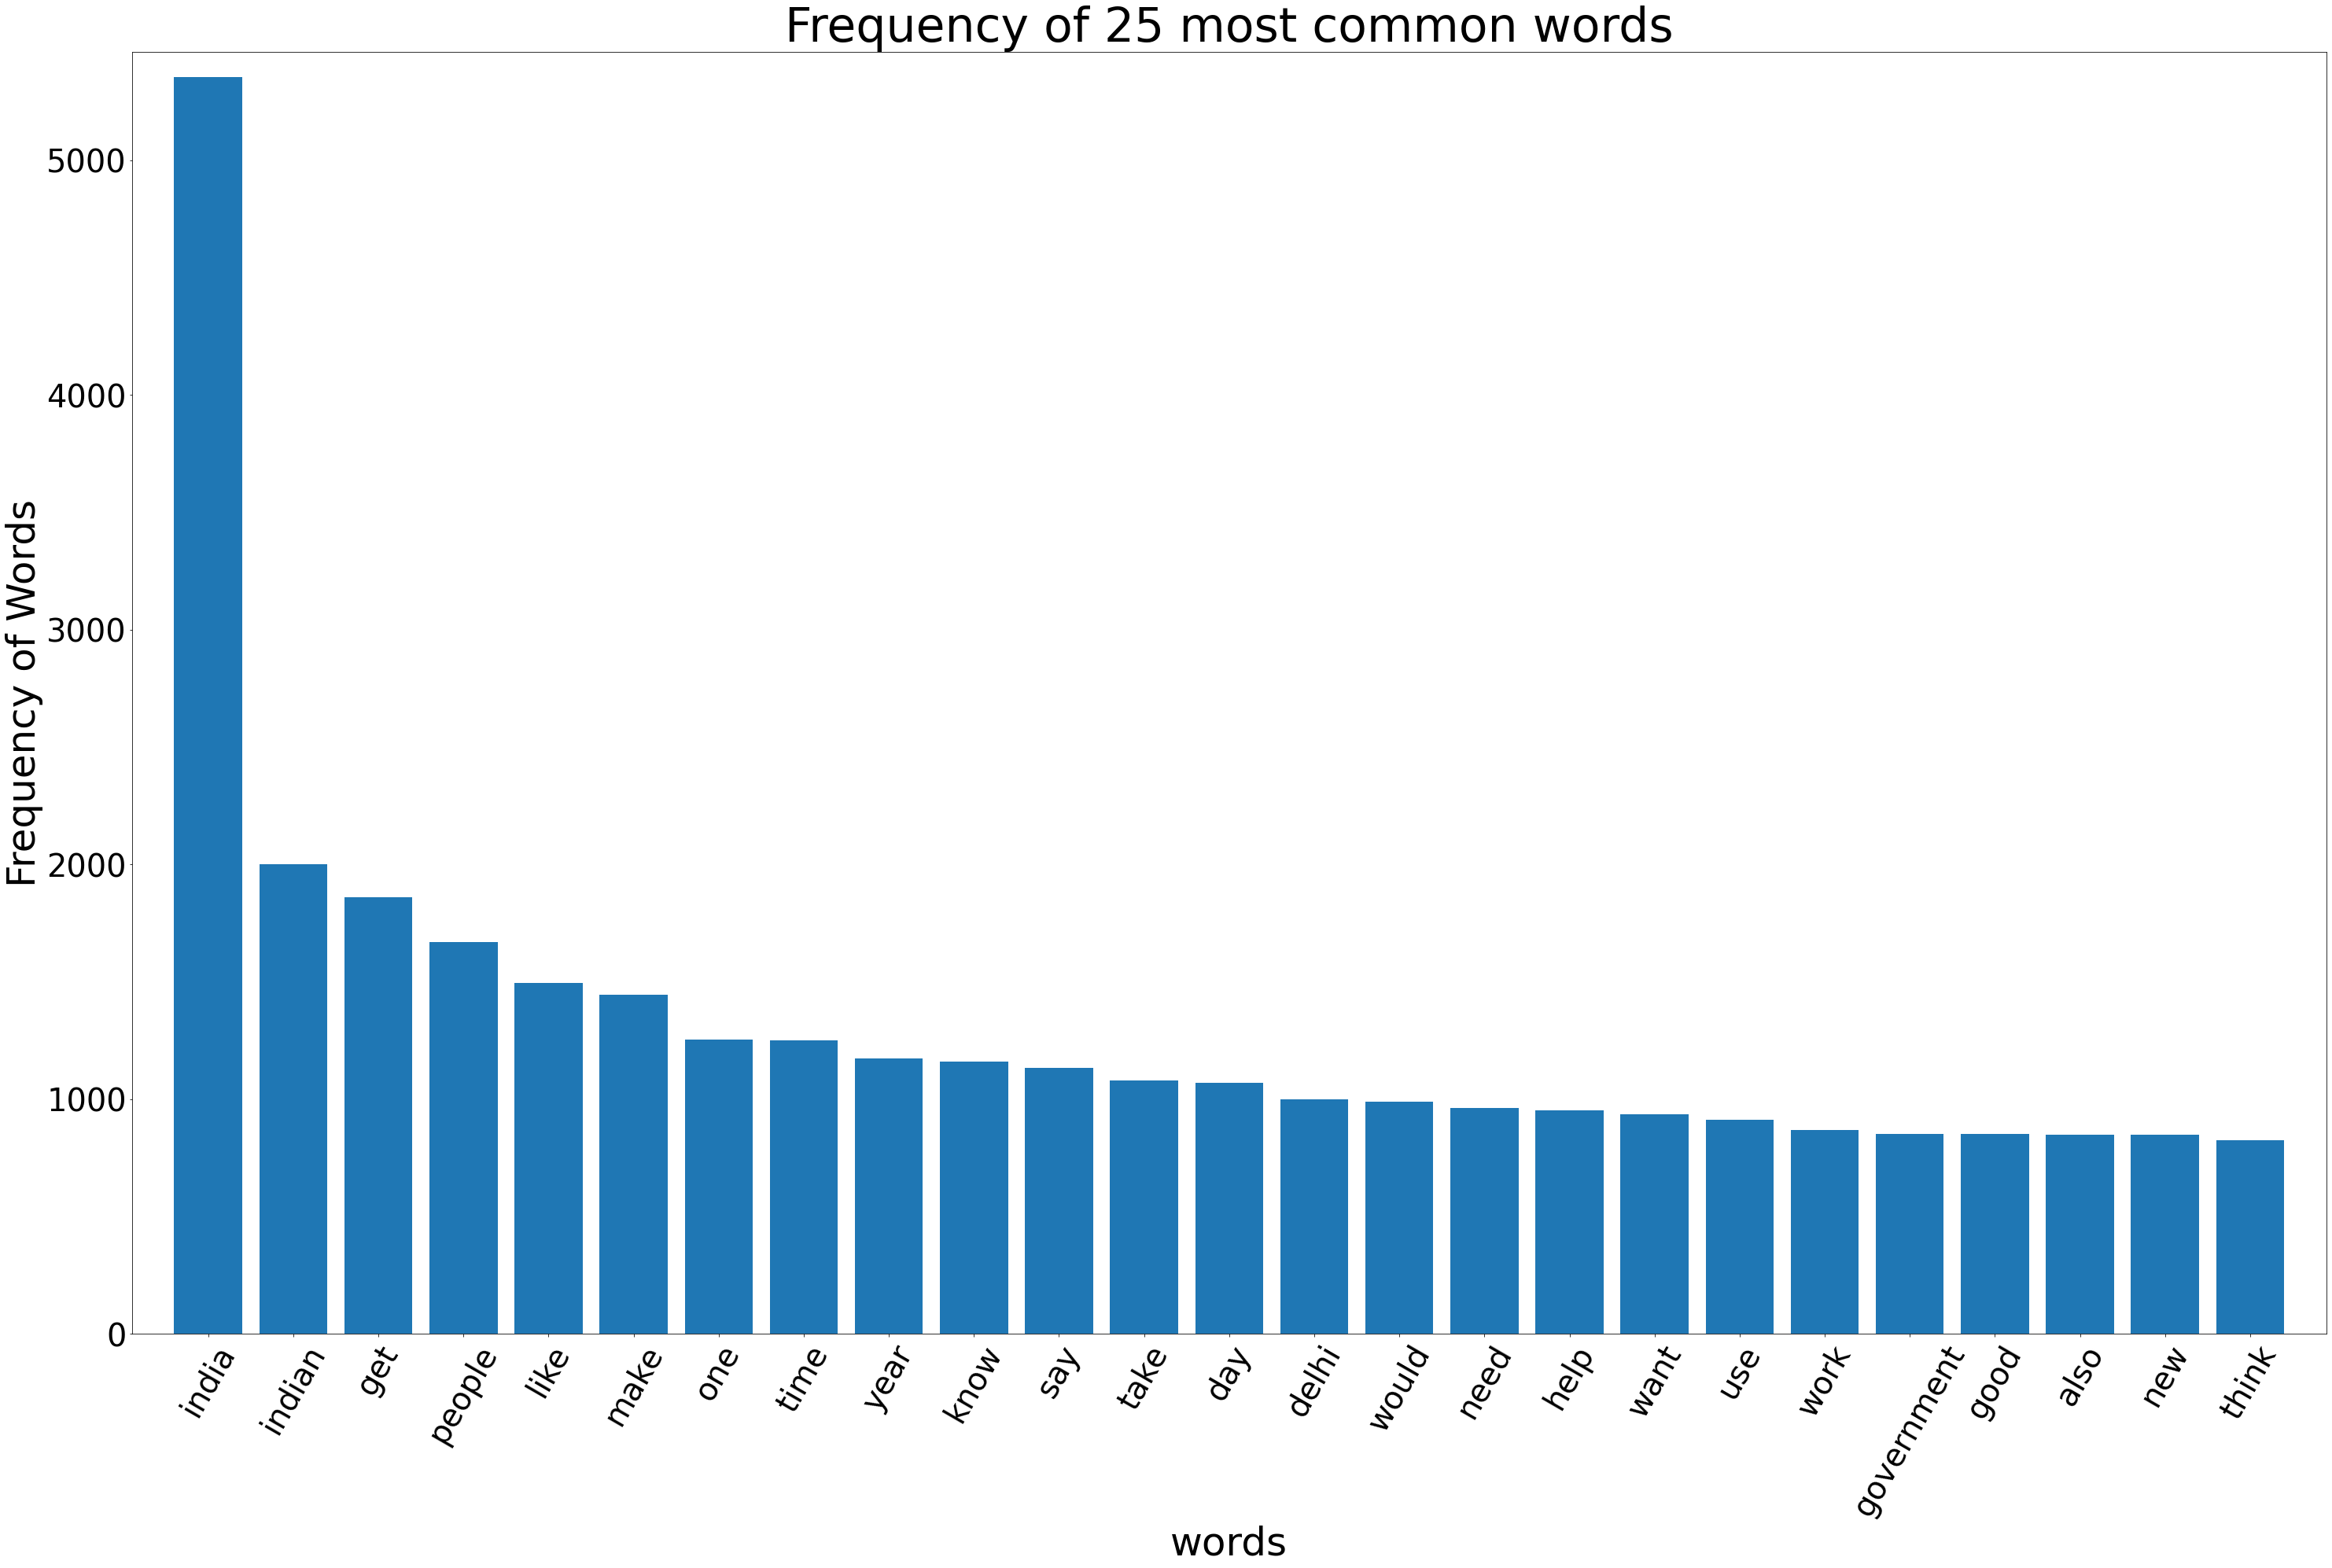

In [11]:
mostcommon = FreqDist(allwords).most_common(25)
x, y = zip(*mostcommon)
plt.figure(figsize=(50, 30))
plt.margins(0.02)
plt.bar(x, y)
plt.xlabel('words', fontsize=50)
plt.ylabel('Frequency of Words', fontsize=50)
plt.yticks(fontsize=40)
plt.xticks(rotation=60, fontsize=40)
plt.title('Frequency of 25 most common words', fontsize=60)
plt.show()

The results depict the obvious, the words 'india' and 'indian' are prevalent as the posts are from r/india

In [12]:
group_by = data.groupby('flair')['small_words_rem_str'].apply(lambda x: Counter(' '.join(x).split()).most_common(25))

In [13]:
group_by

flair
AskIndia              [(india, 763), (get, 601), (like, 451), (india...
Business/Finance      [(india, 498), (top, 222), (manufacturer, 195)...
CAA-NRC               [(caa, 423), (delhi, 271), (protest, 200), (in...
Coronavirus           [(covid, 506), (coronavirus, 488), (india, 482...
Food                  [(food, 341), (india, 214), (recipe, 209), (in...
Photography           [(india, 272), (shot, 163), (delhi, 98), (take...
Policy/Economy        [(india, 861), (government, 311), (report, 284...
Politics              [(india, 456), (modi, 332), (bjp, 305), (peopl...
Science/Technology    [(india, 578), (indian, 172), (get, 167), (use...
Sports                [(india, 633), (cricket, 373), (world, 348), (...
[R]eddiquette         [(india, 403), (get, 217), (song, 184), (woman...
Name: small_words_rem_str, dtype: object

In [14]:
flairs = ['Business/Finance', 'Policy/Economy', 'Photography', 'Politics', 'Sports', '[R]eddiquette', 'Food', 'Science/Technology', 'AskIndia','CAA-NRC', 'Coronavirus']

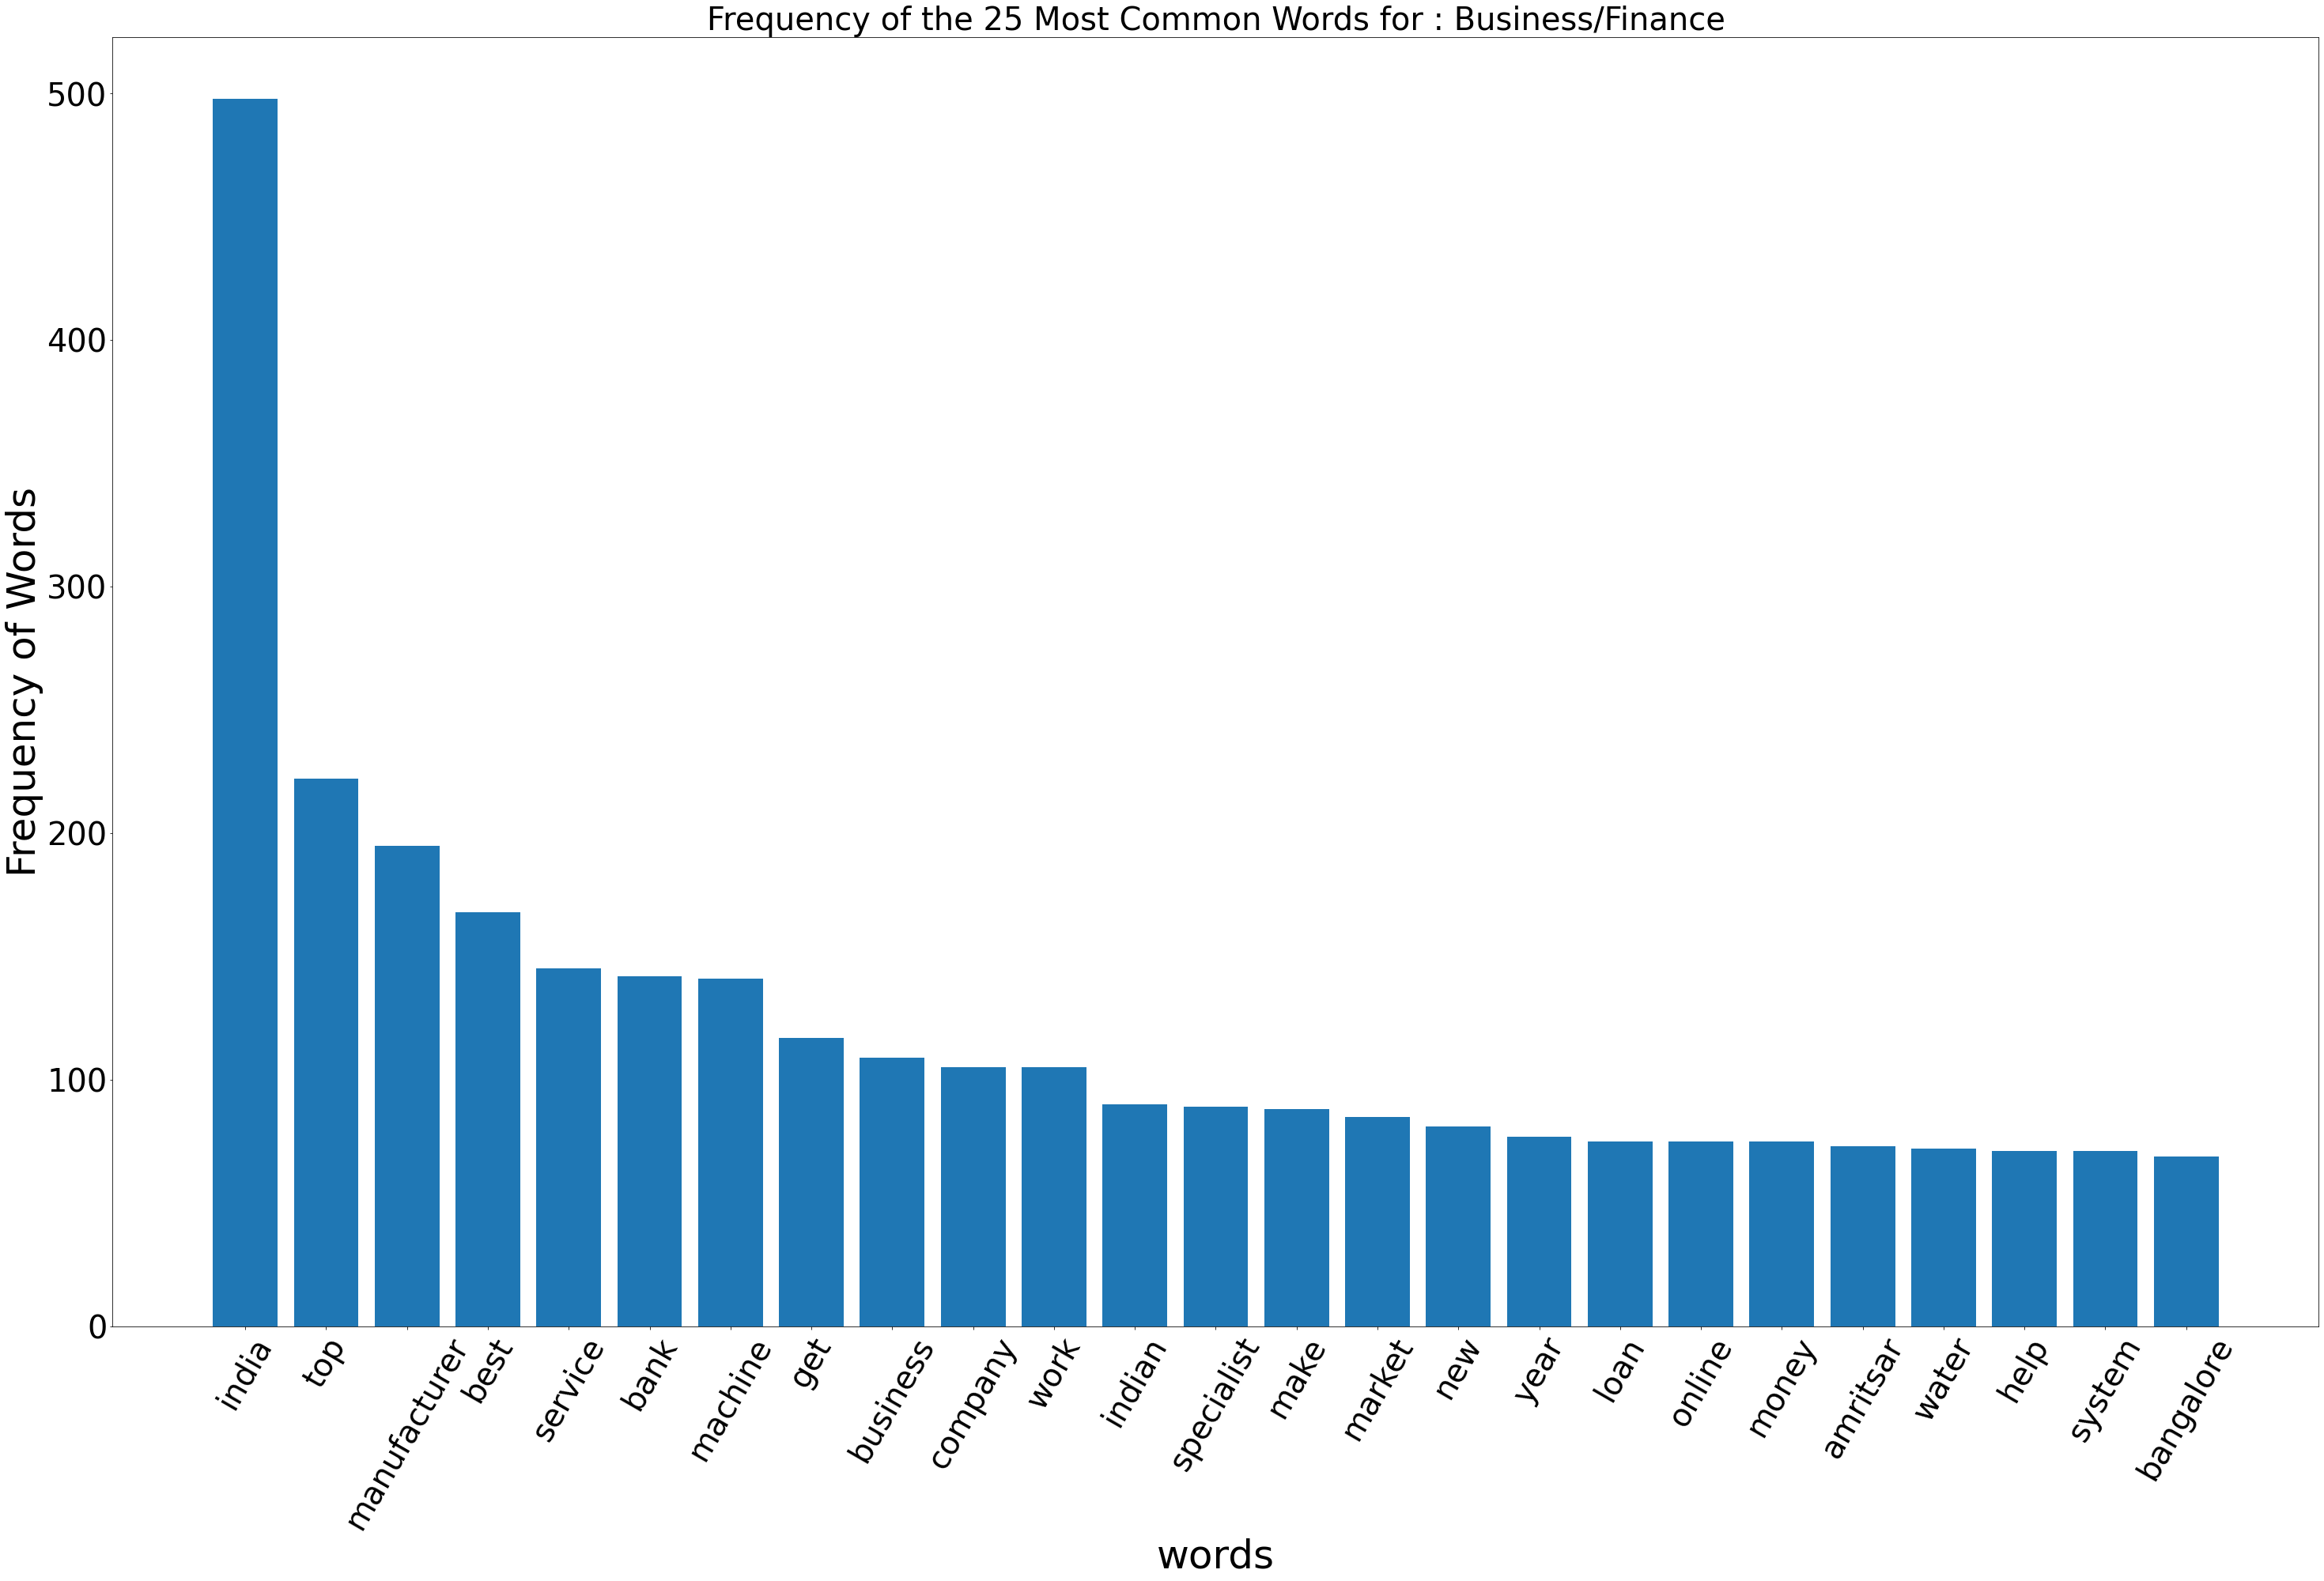

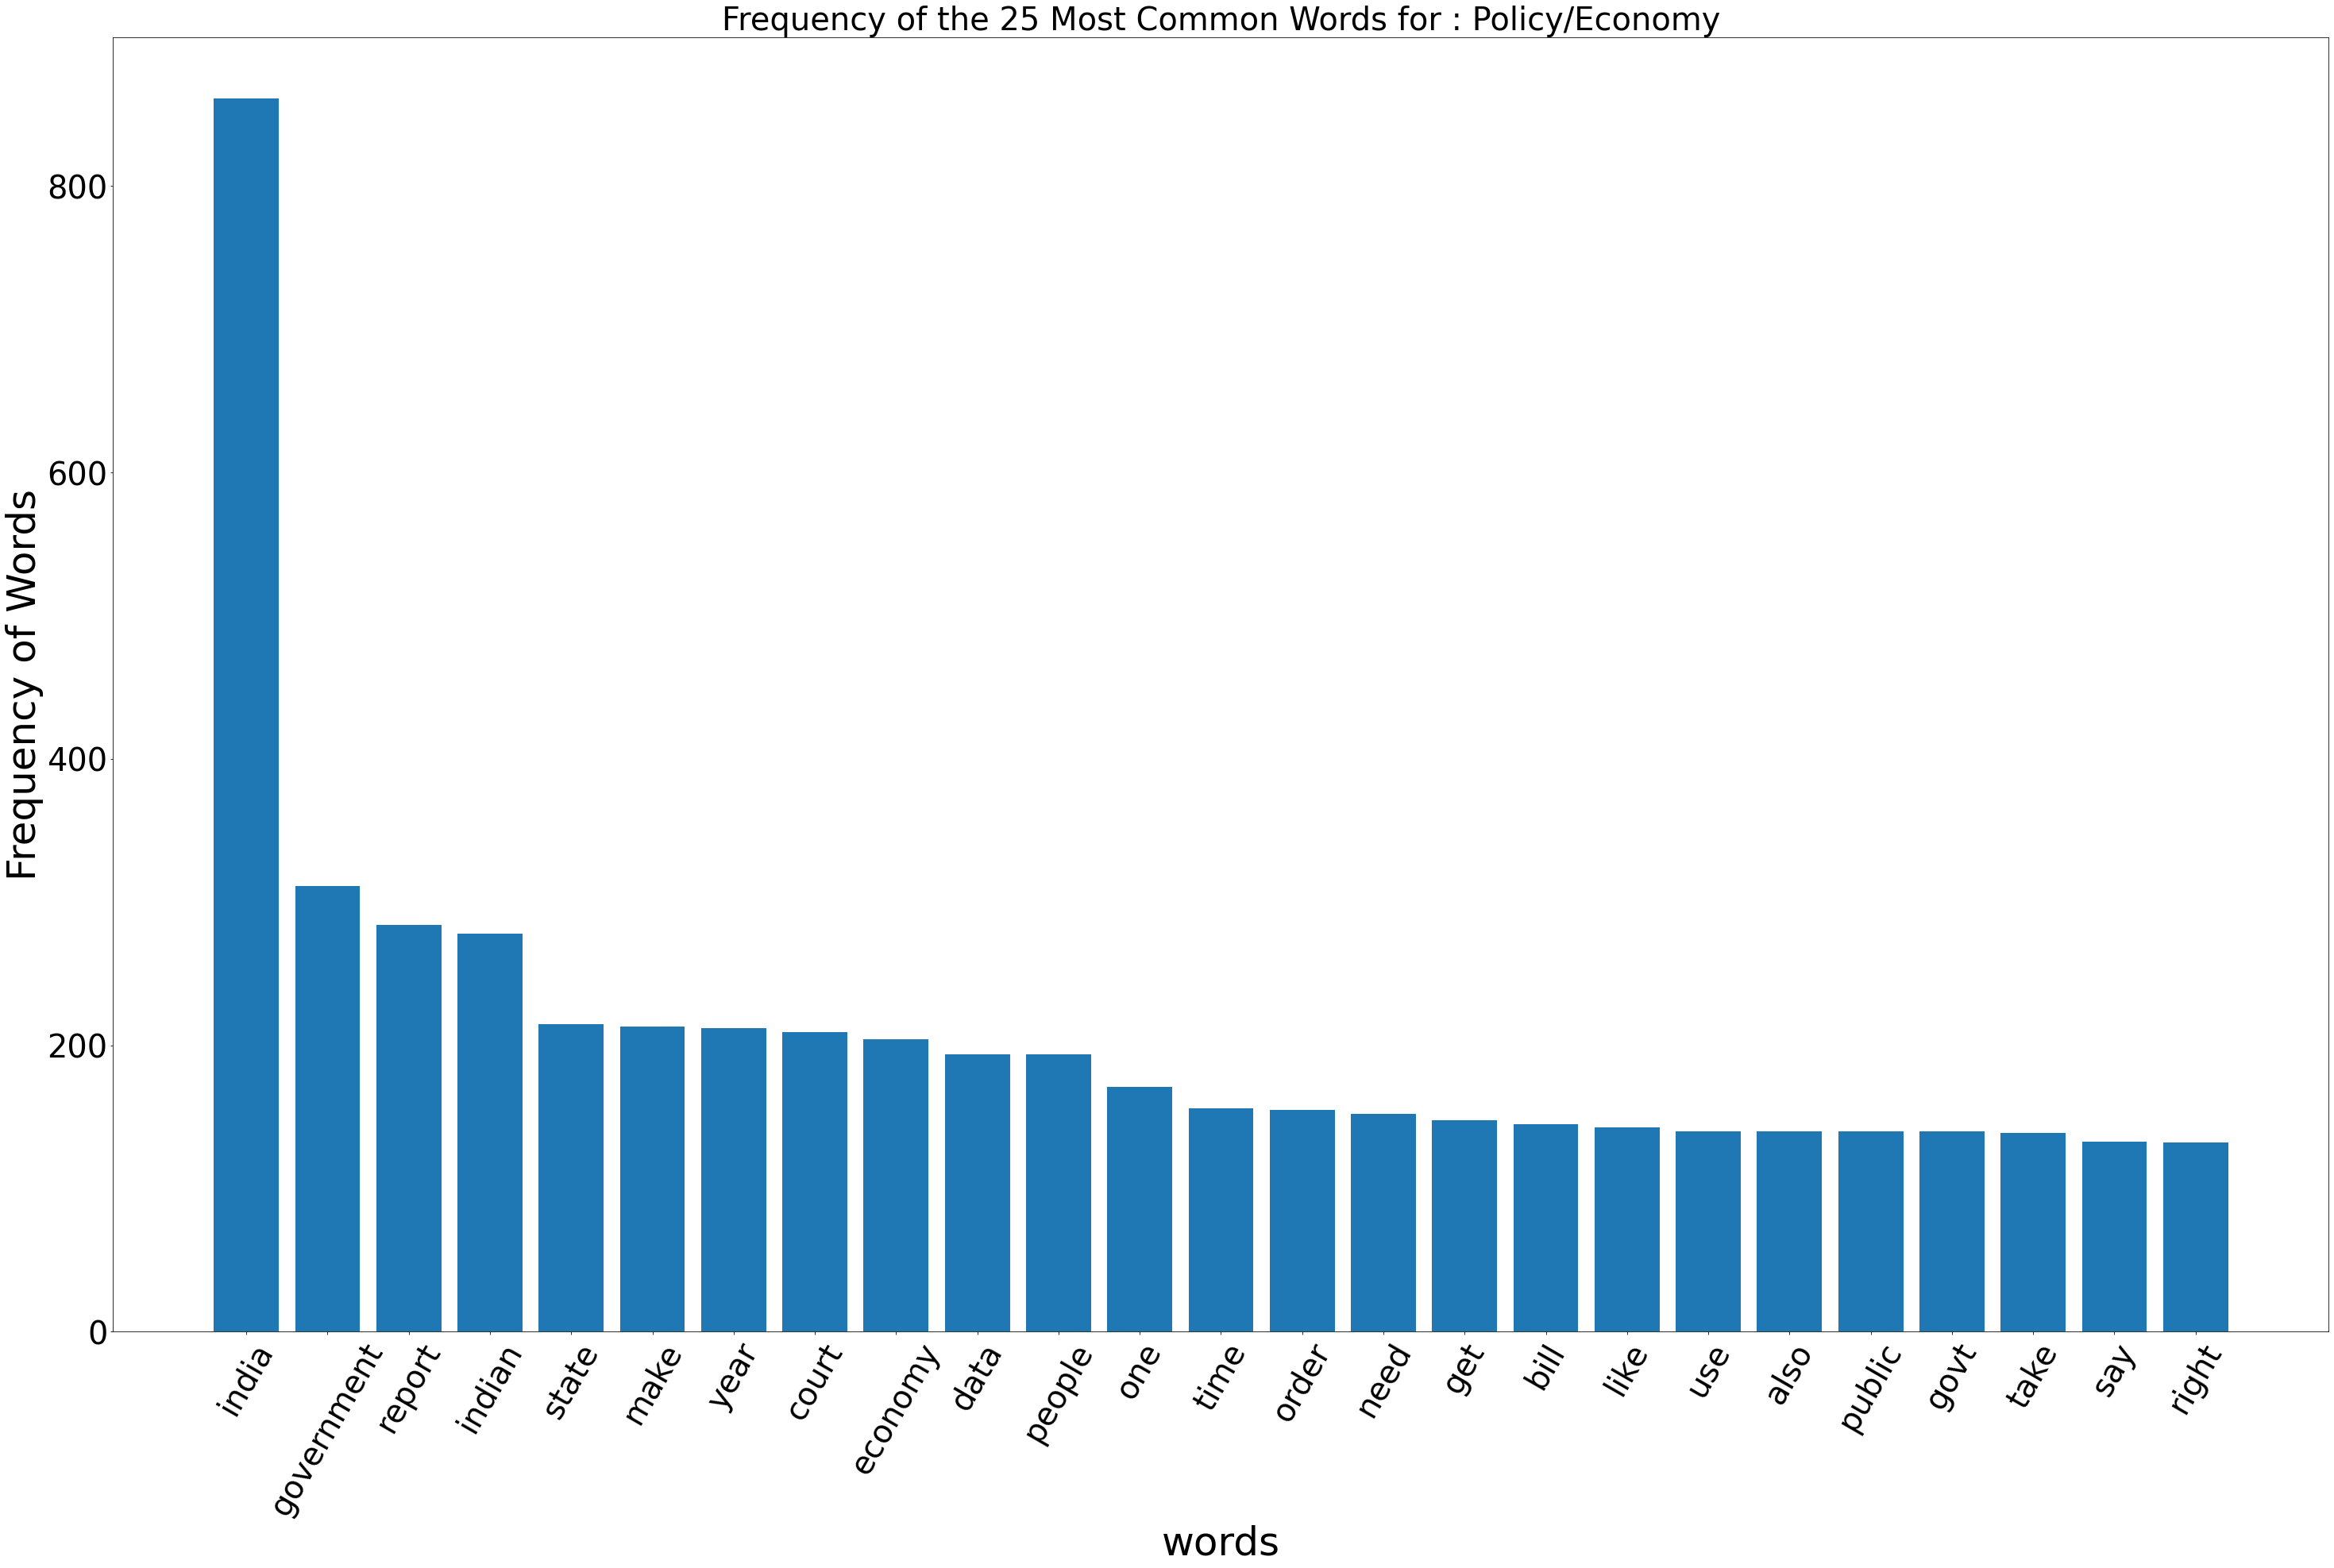

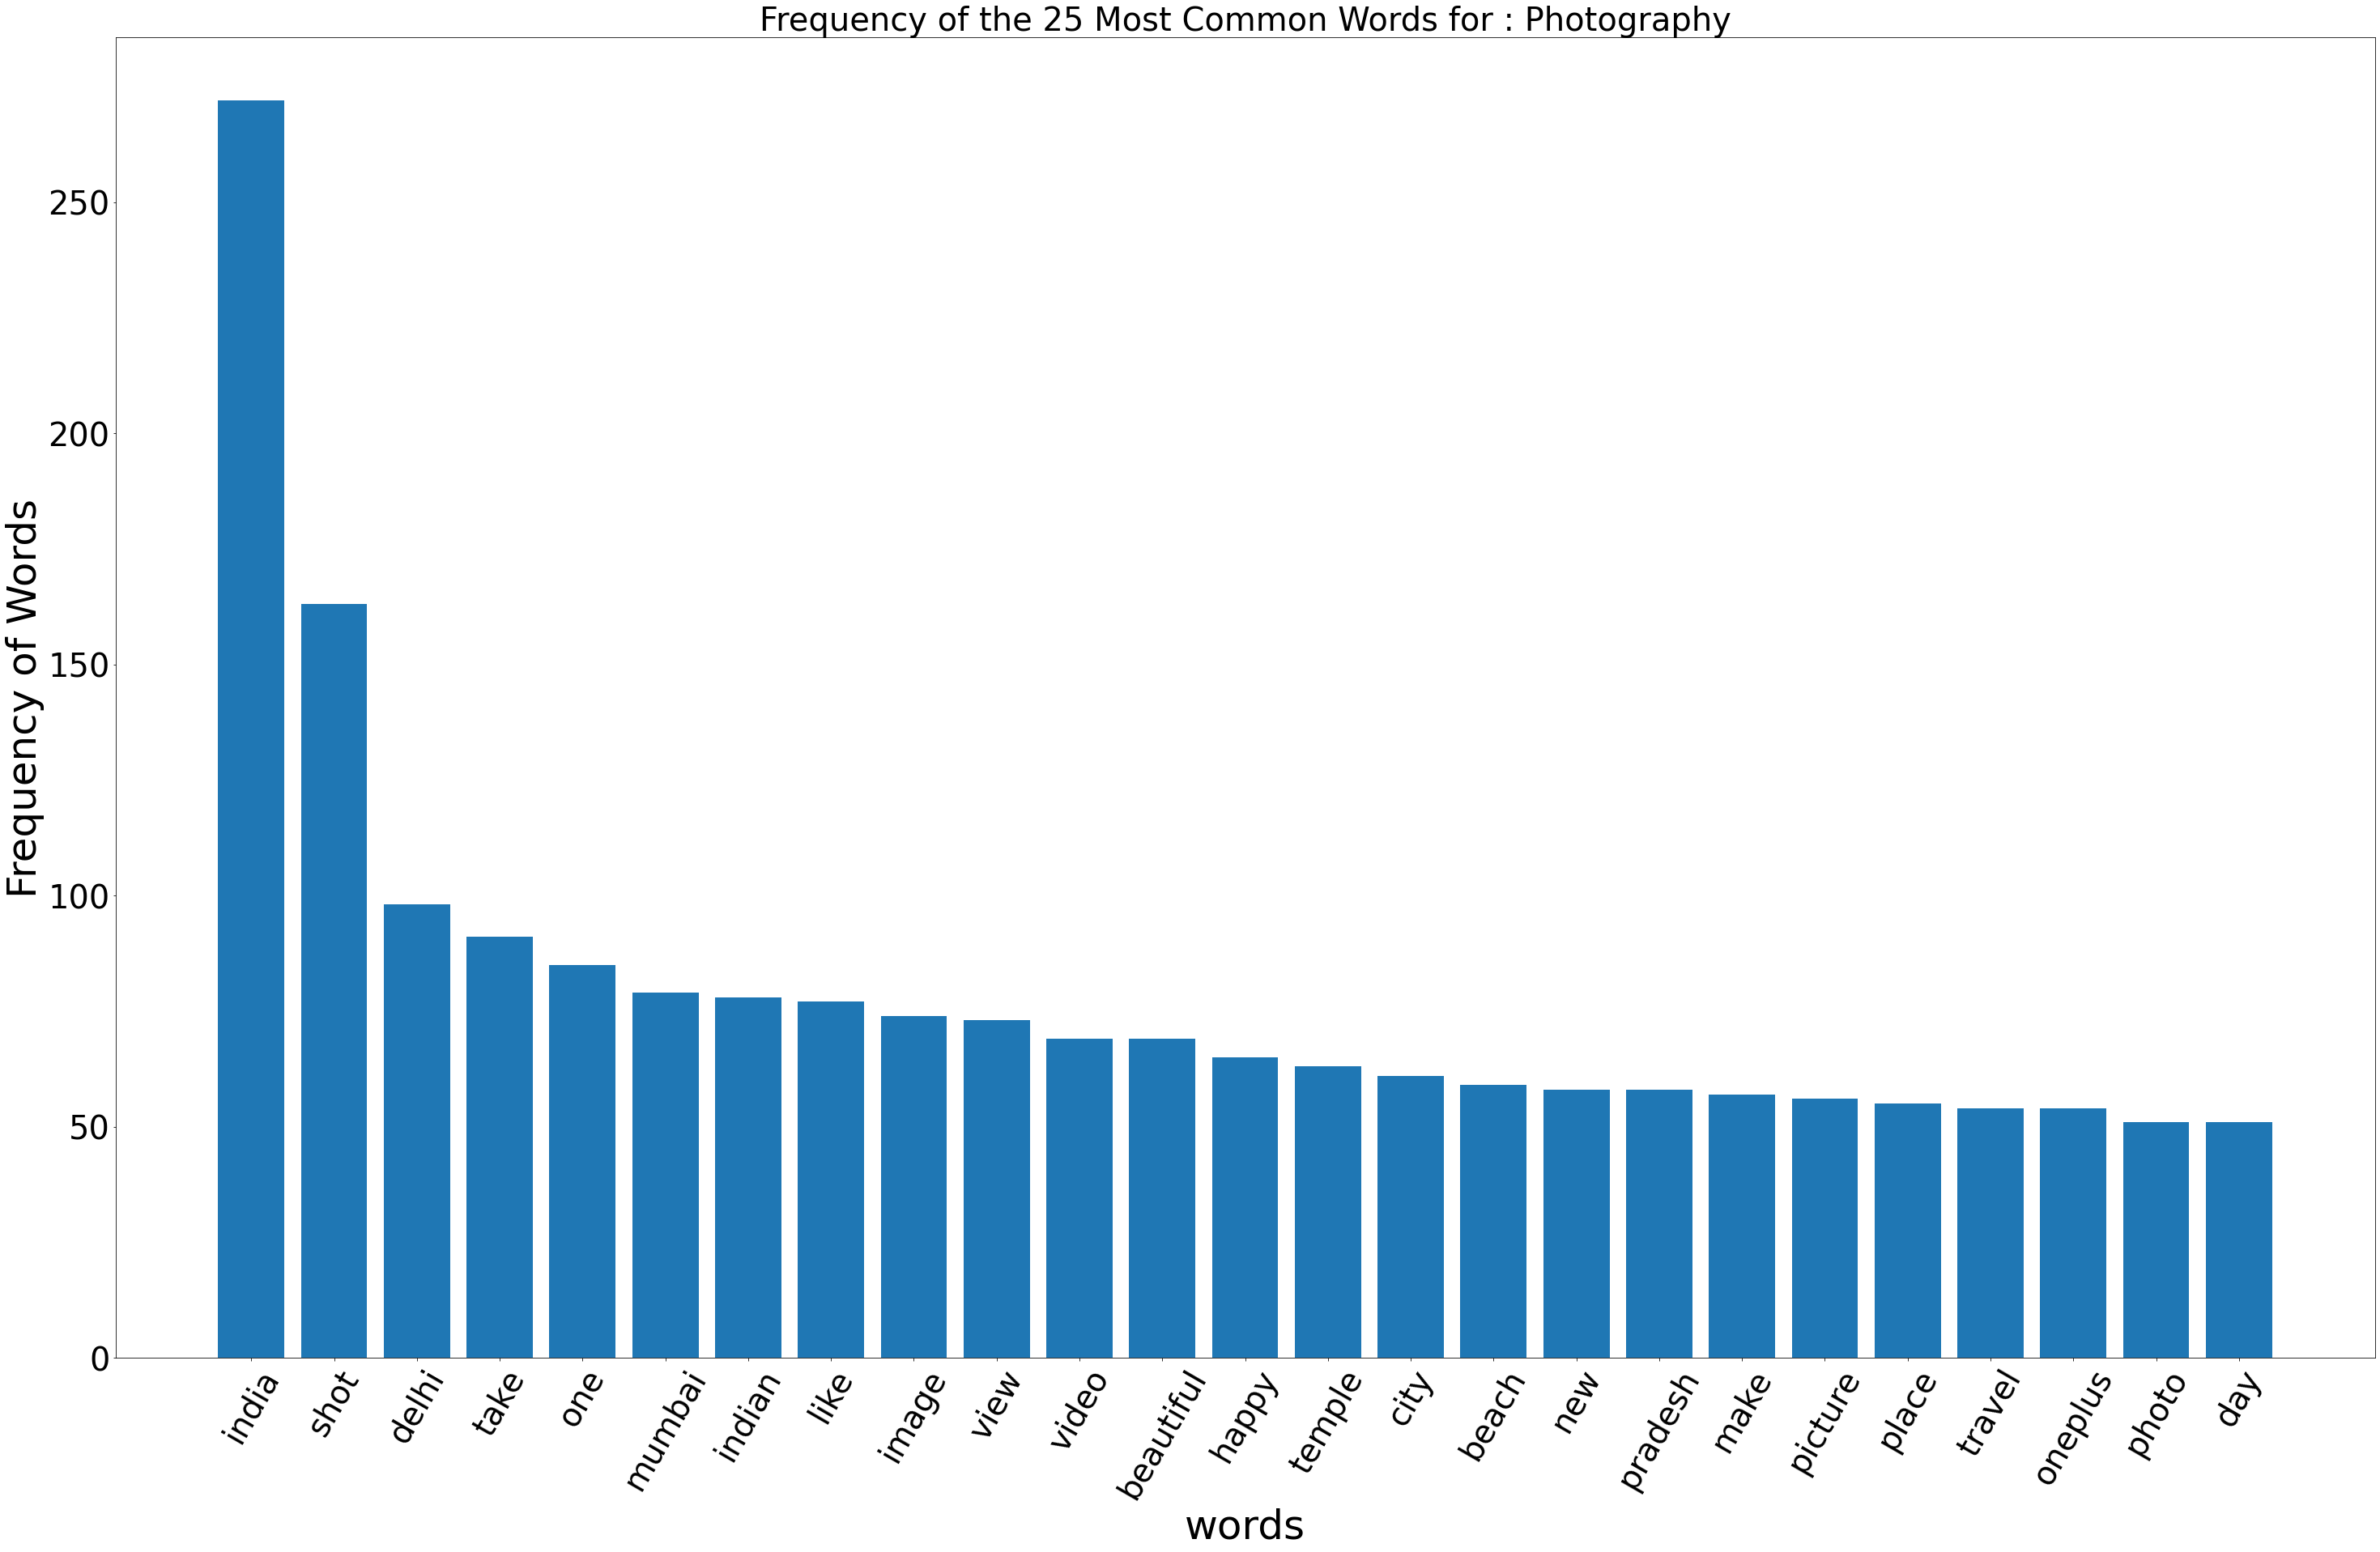

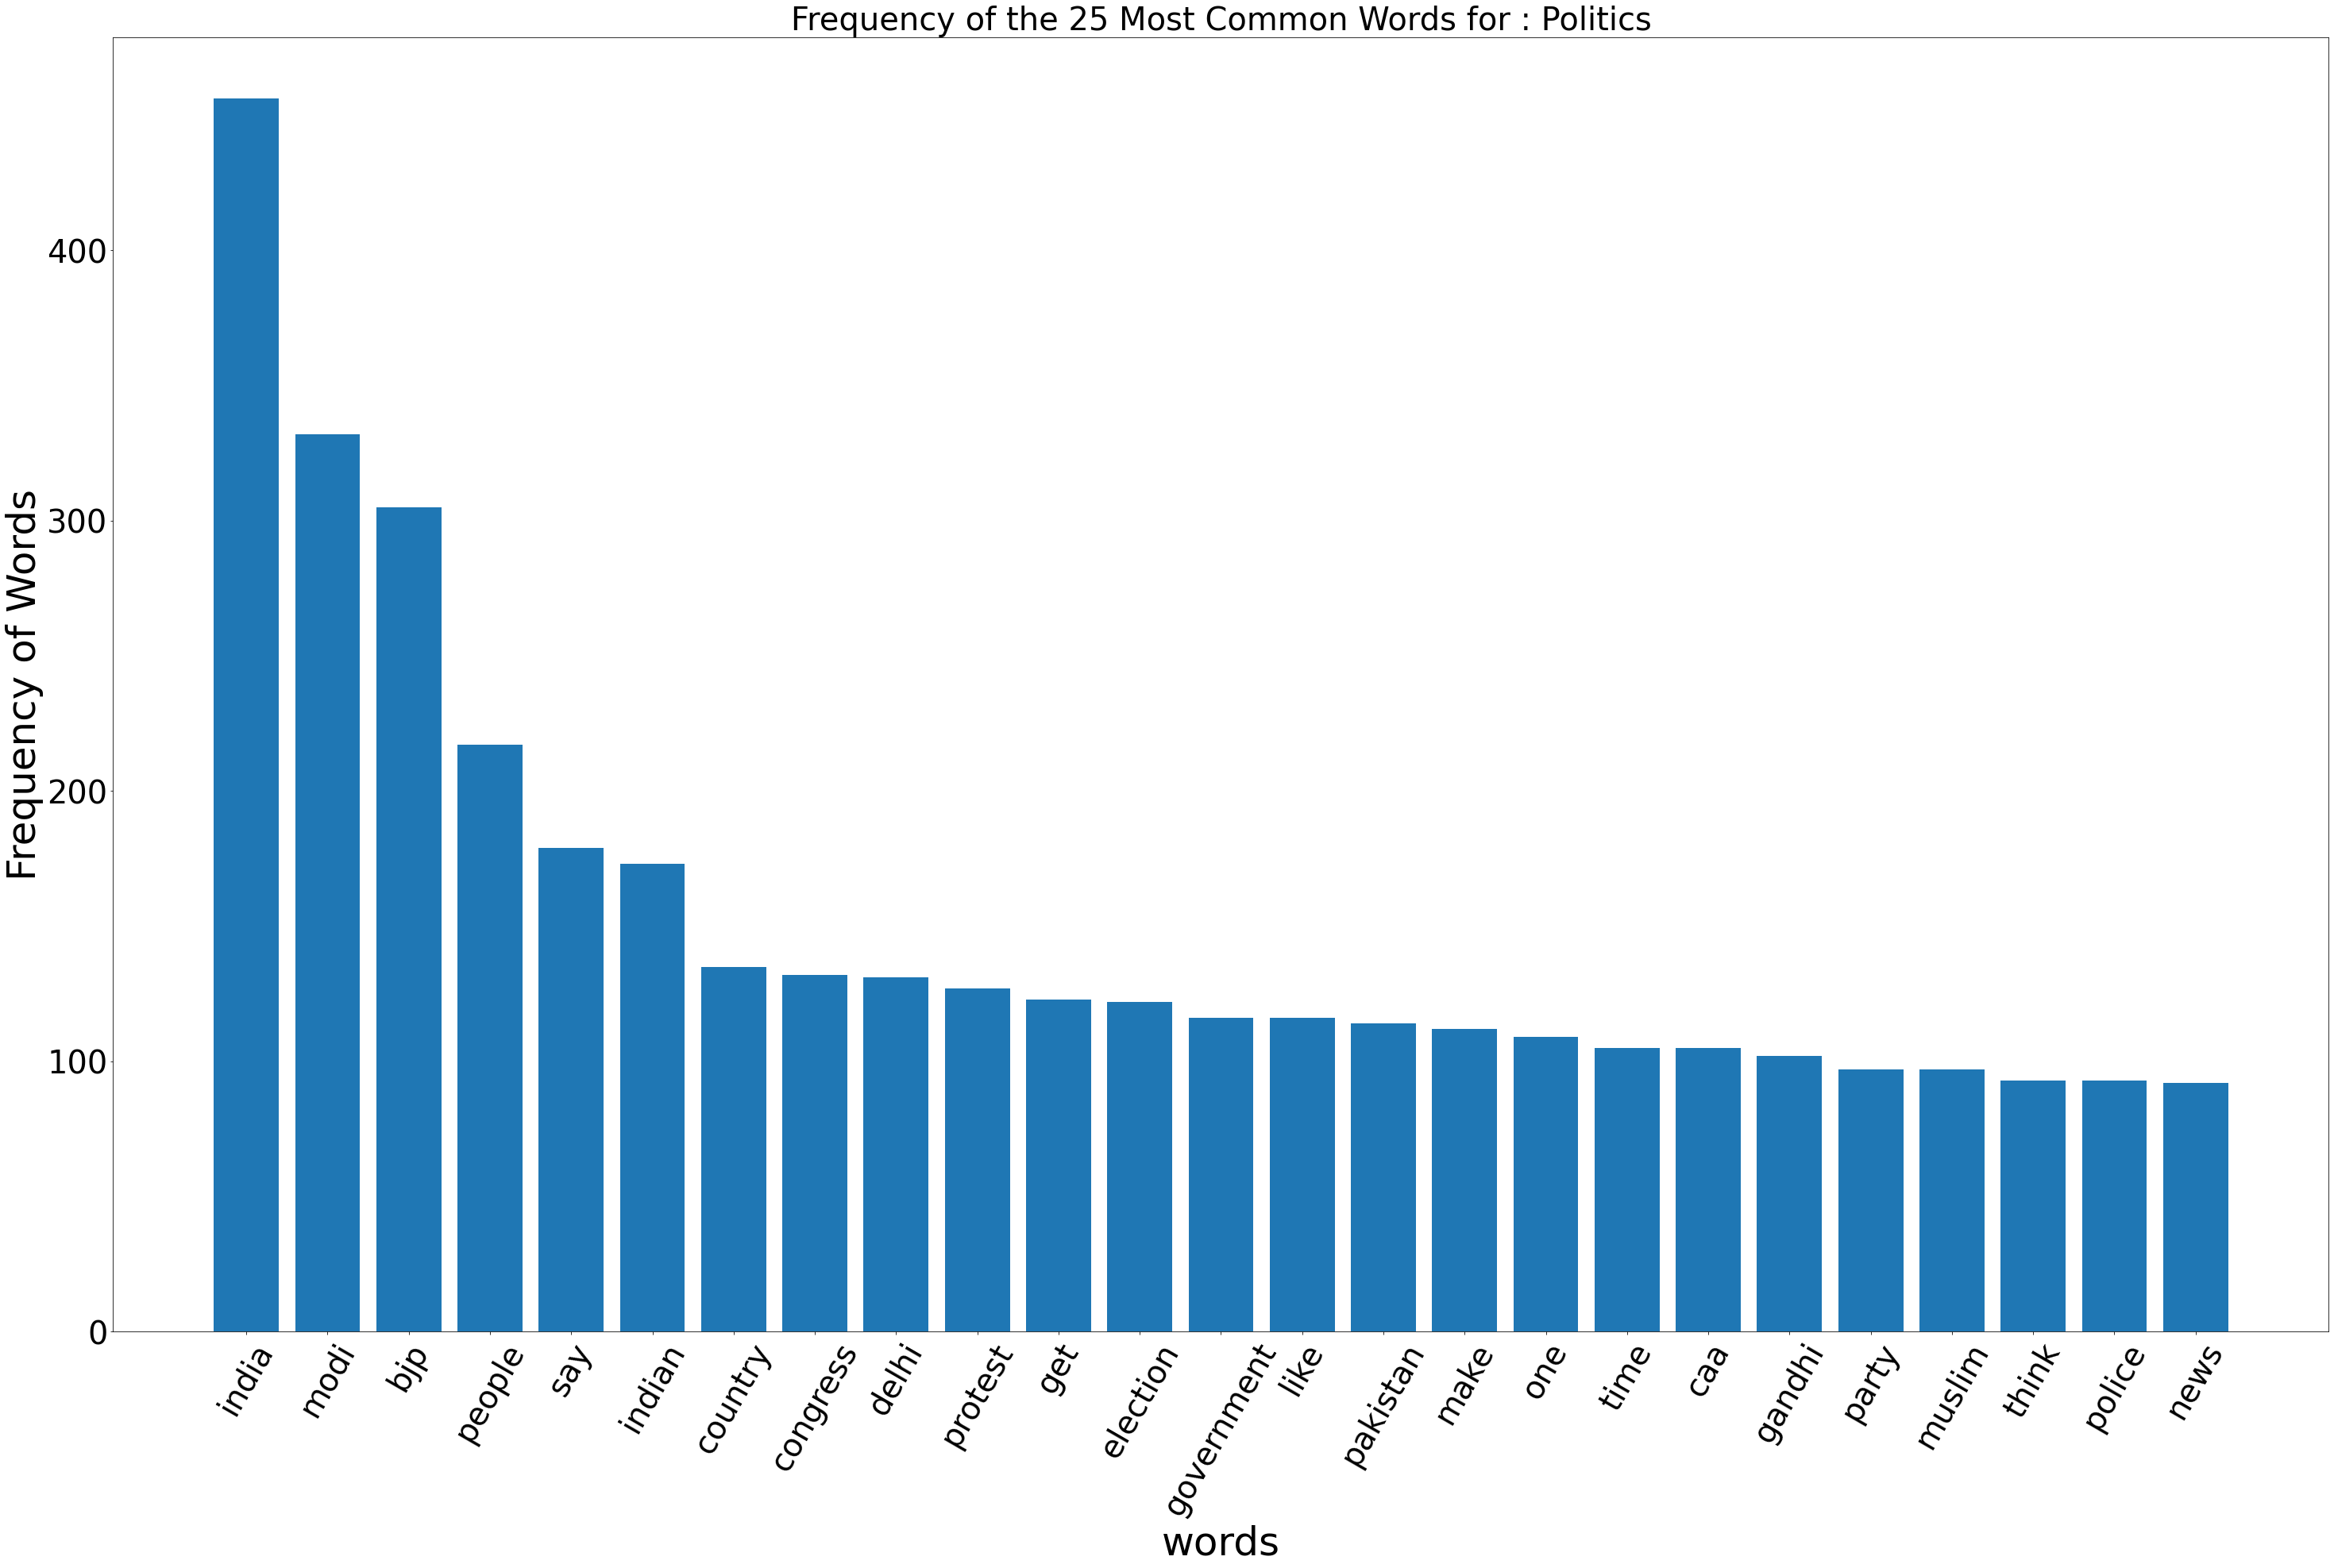

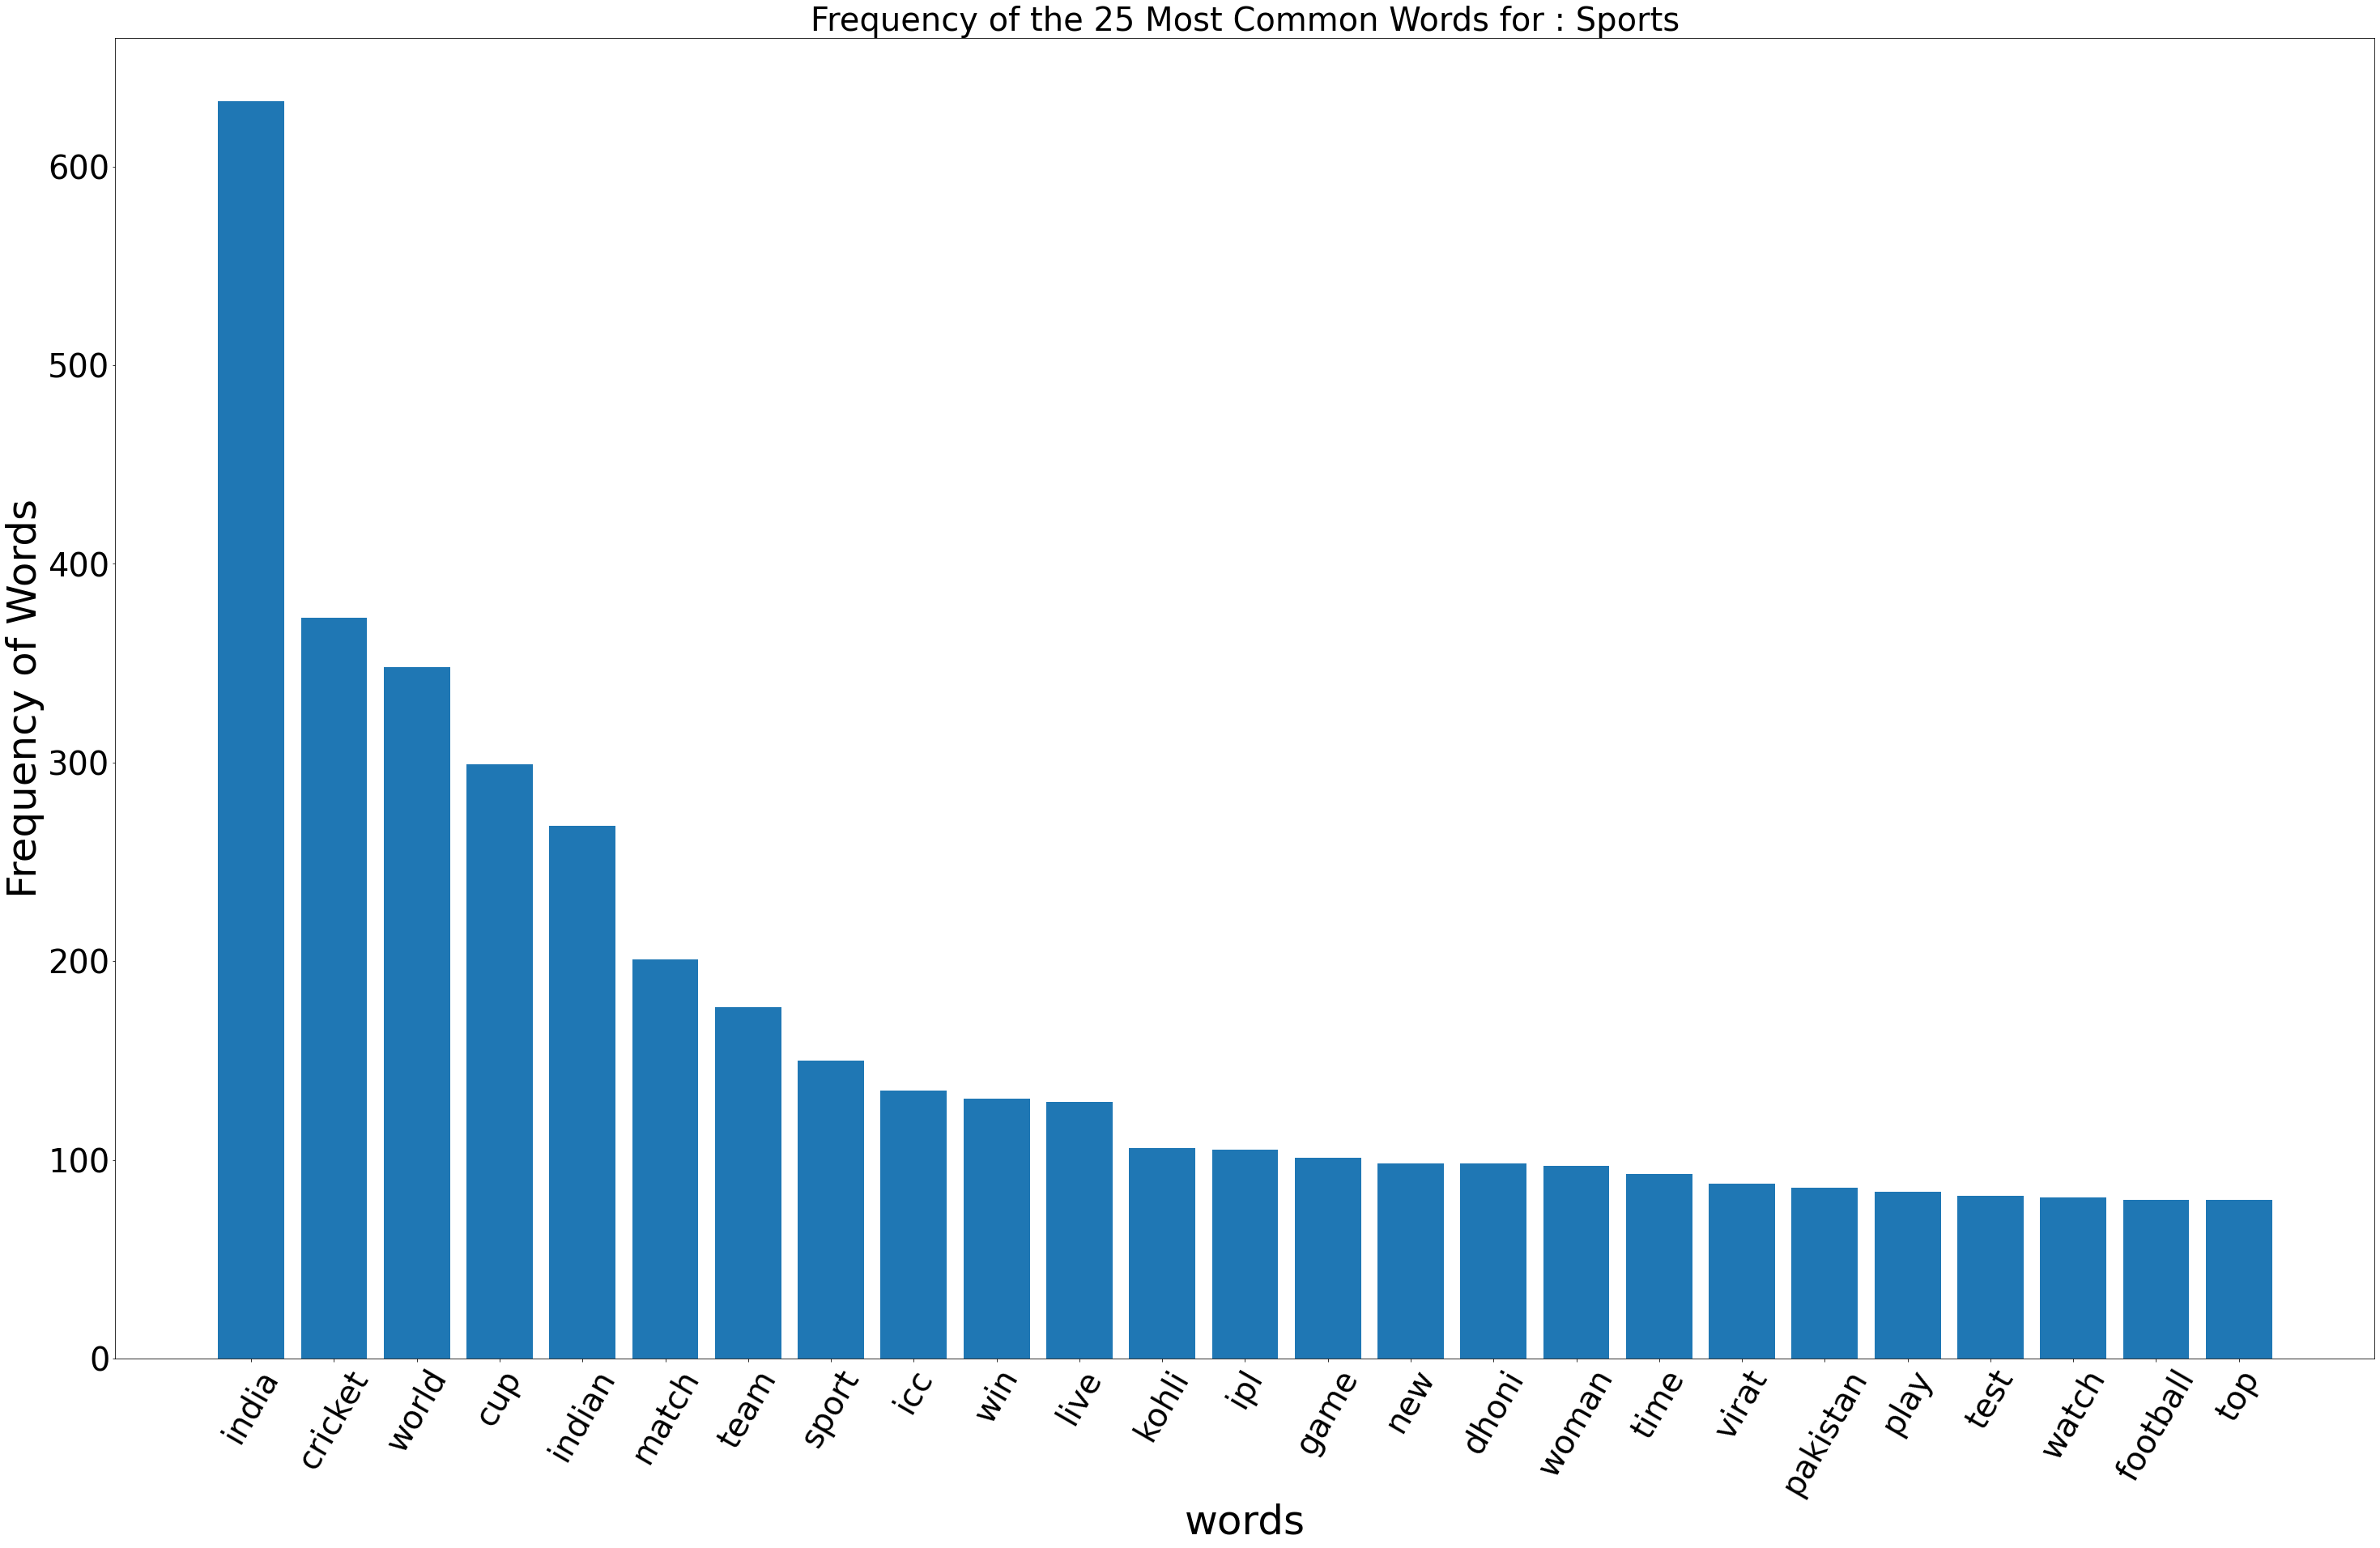

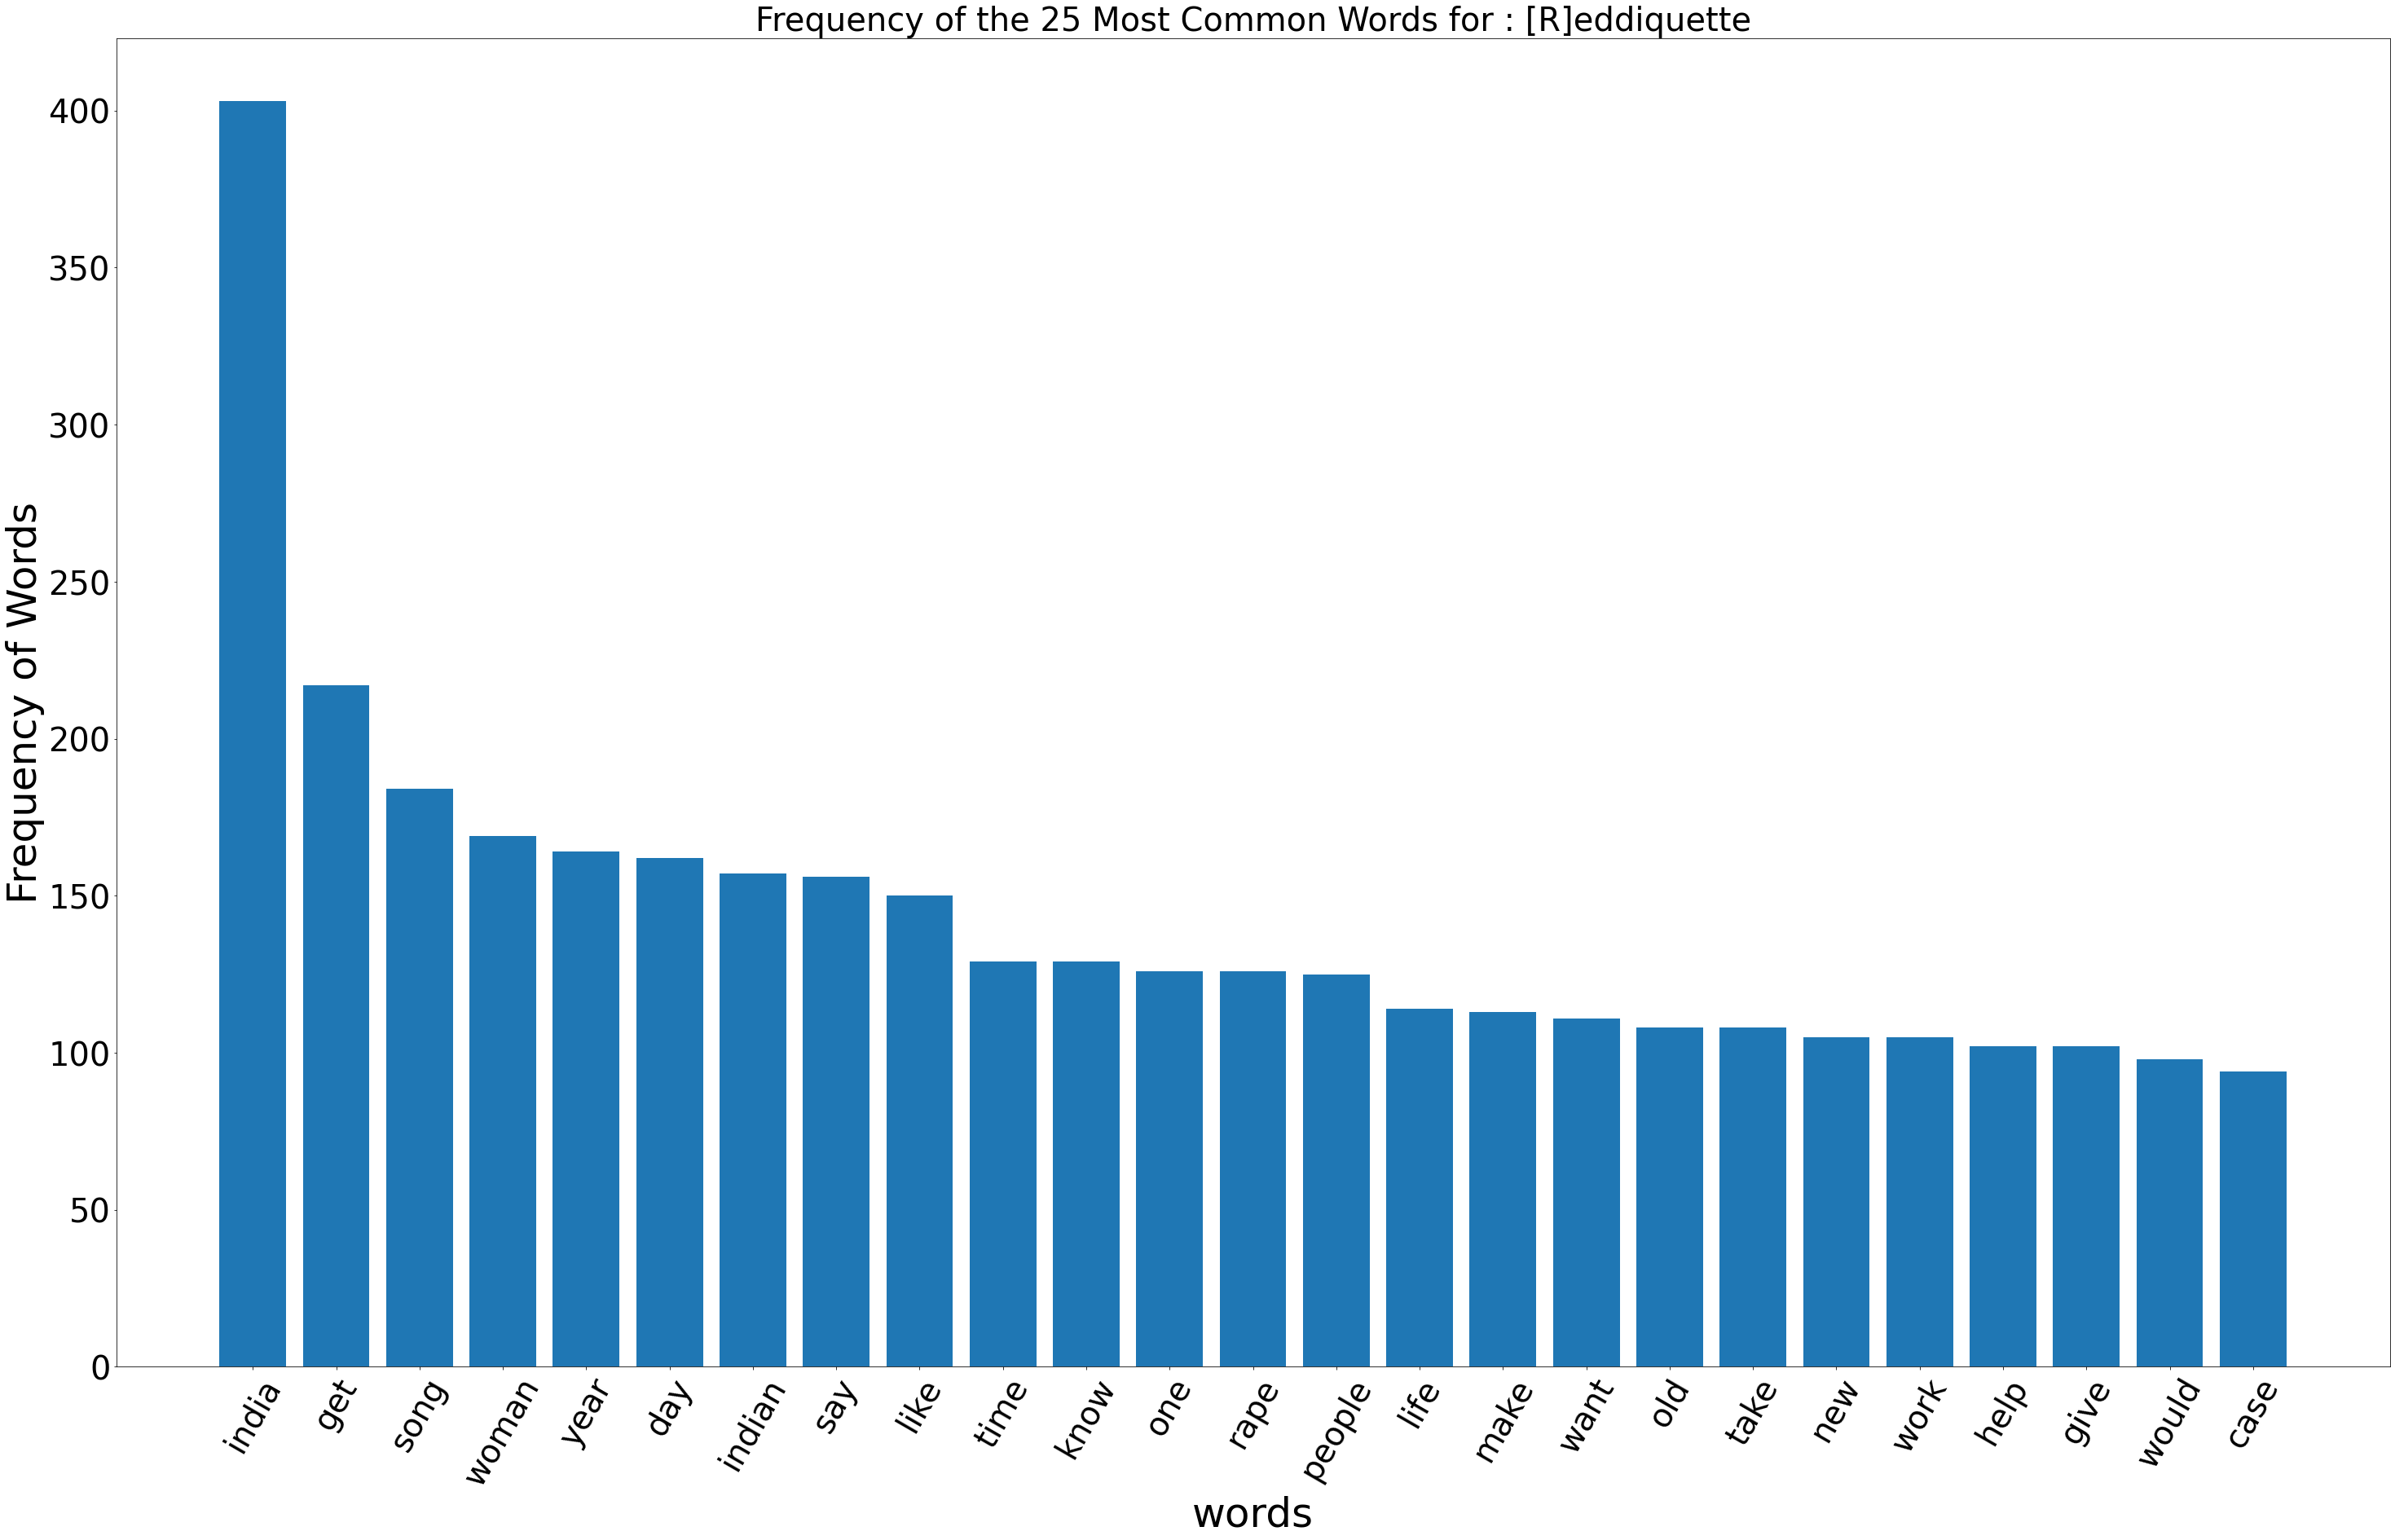

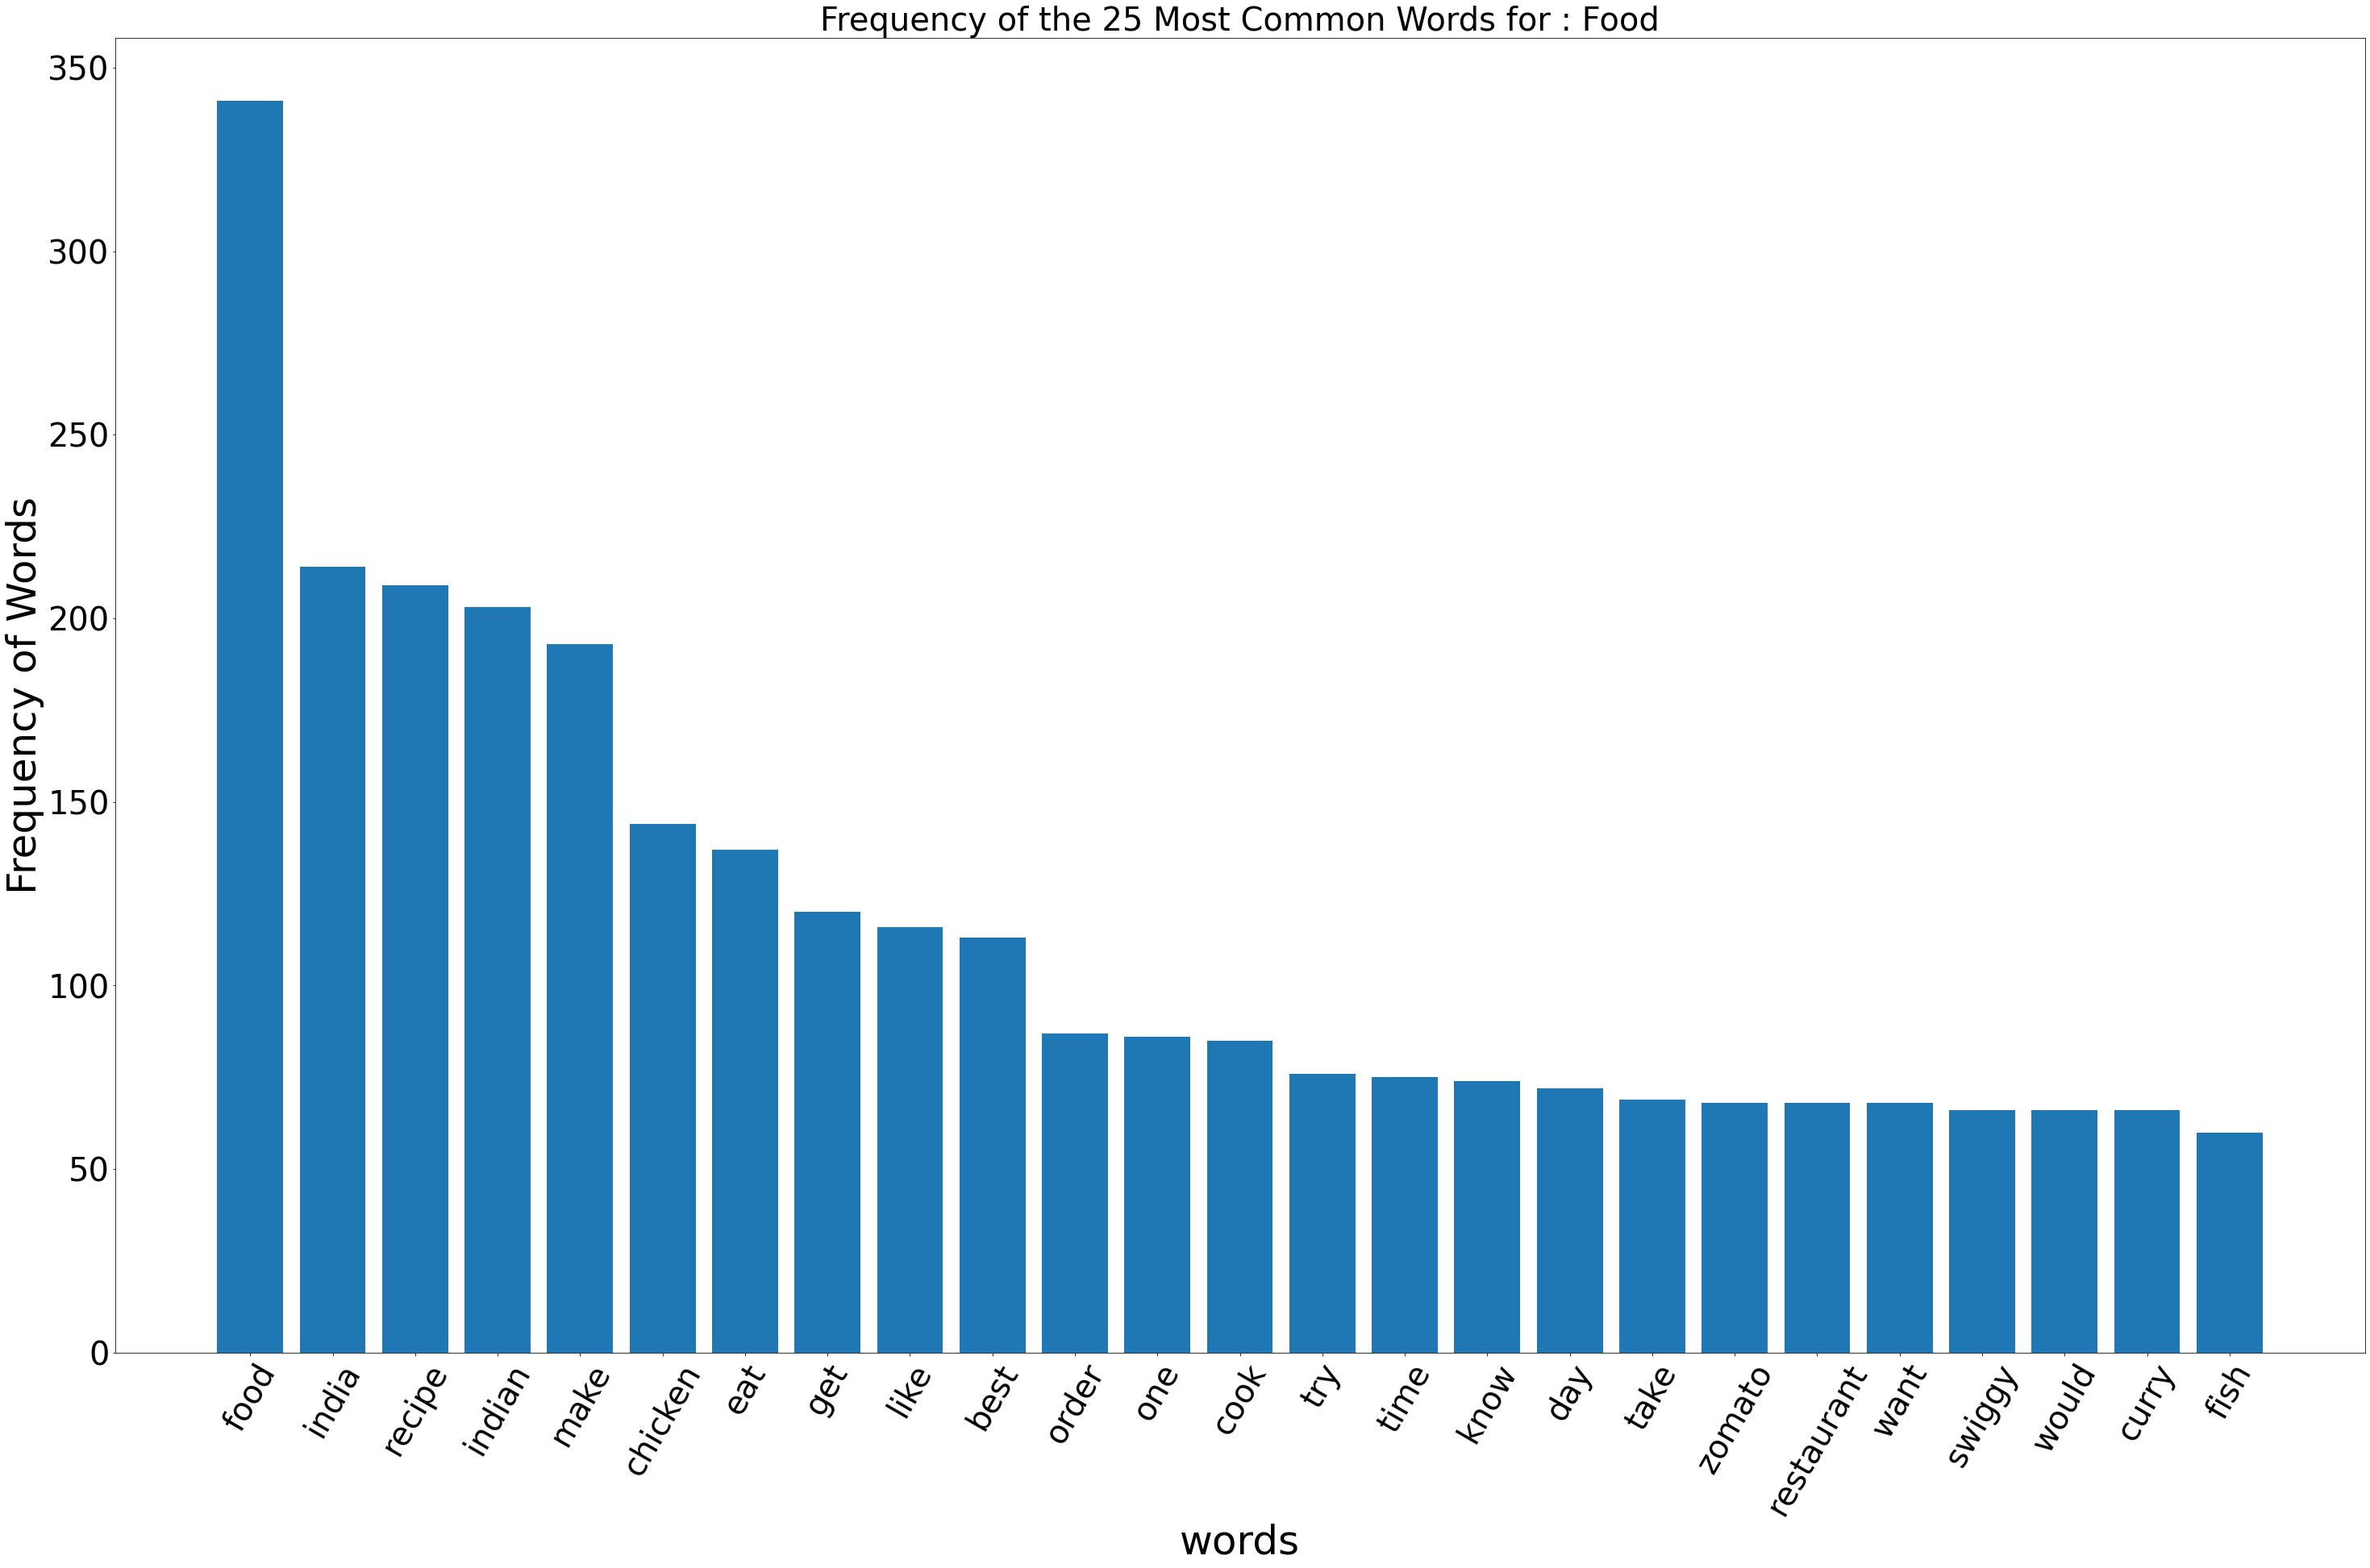

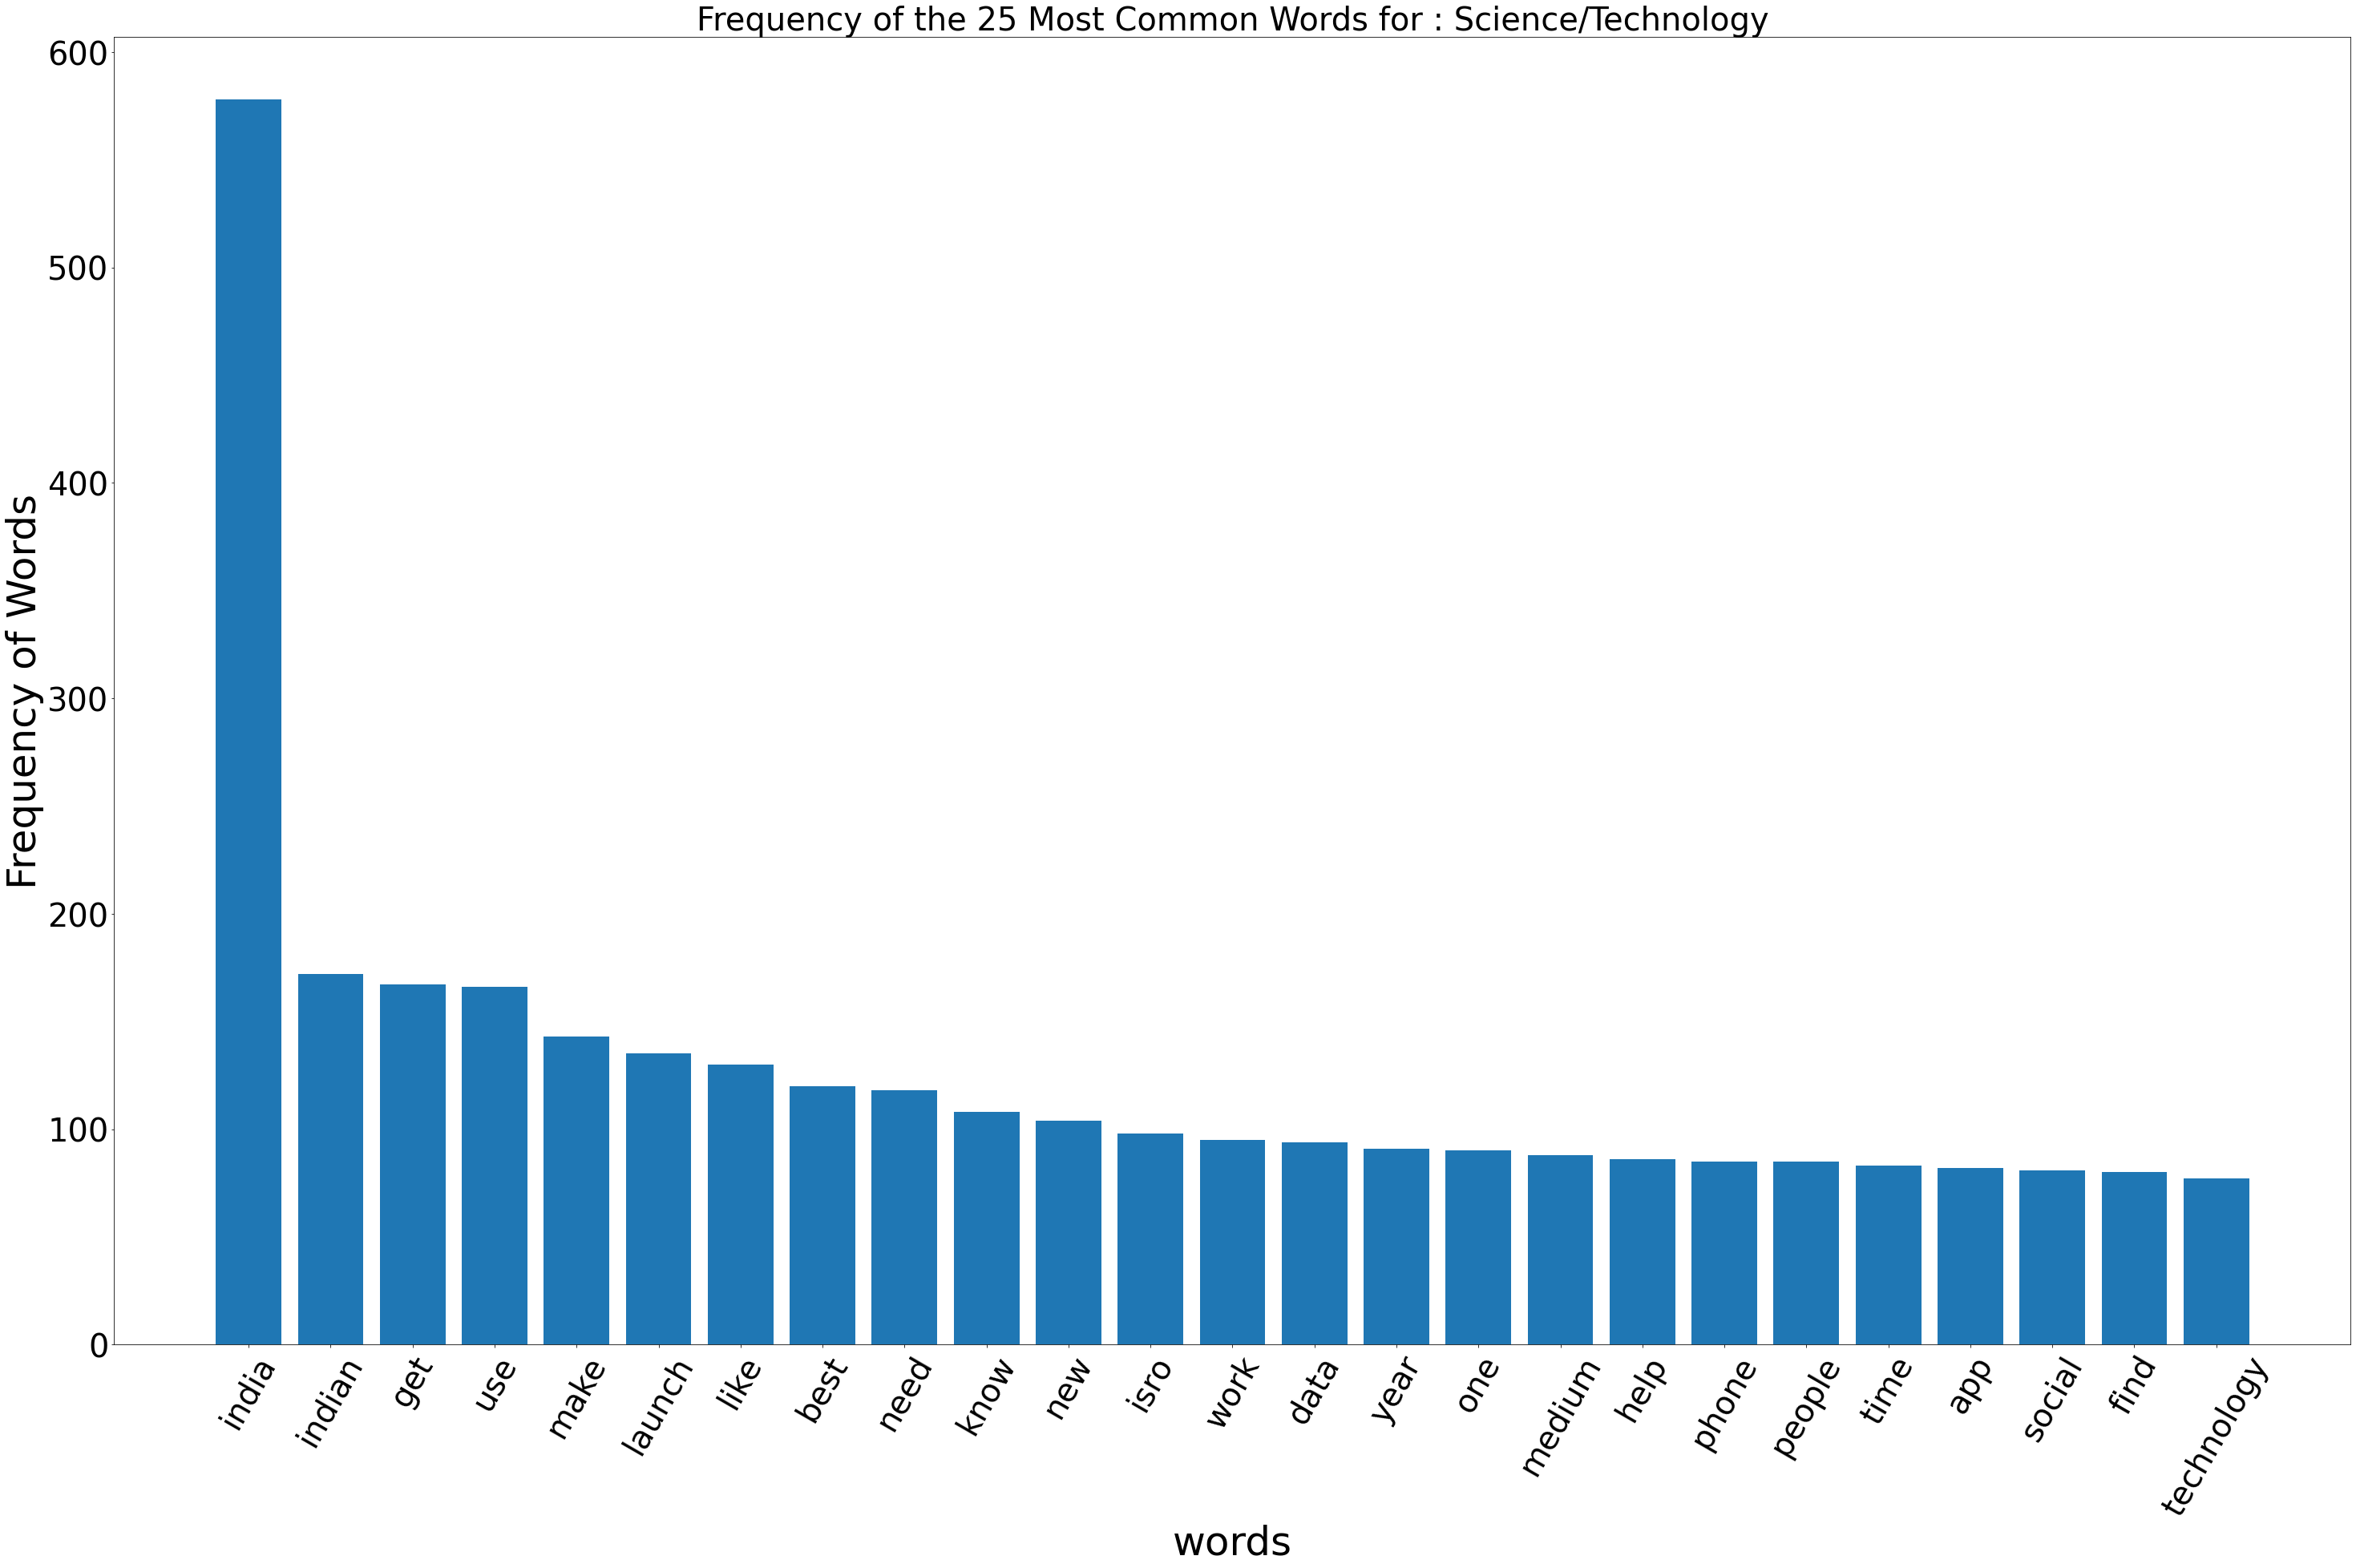

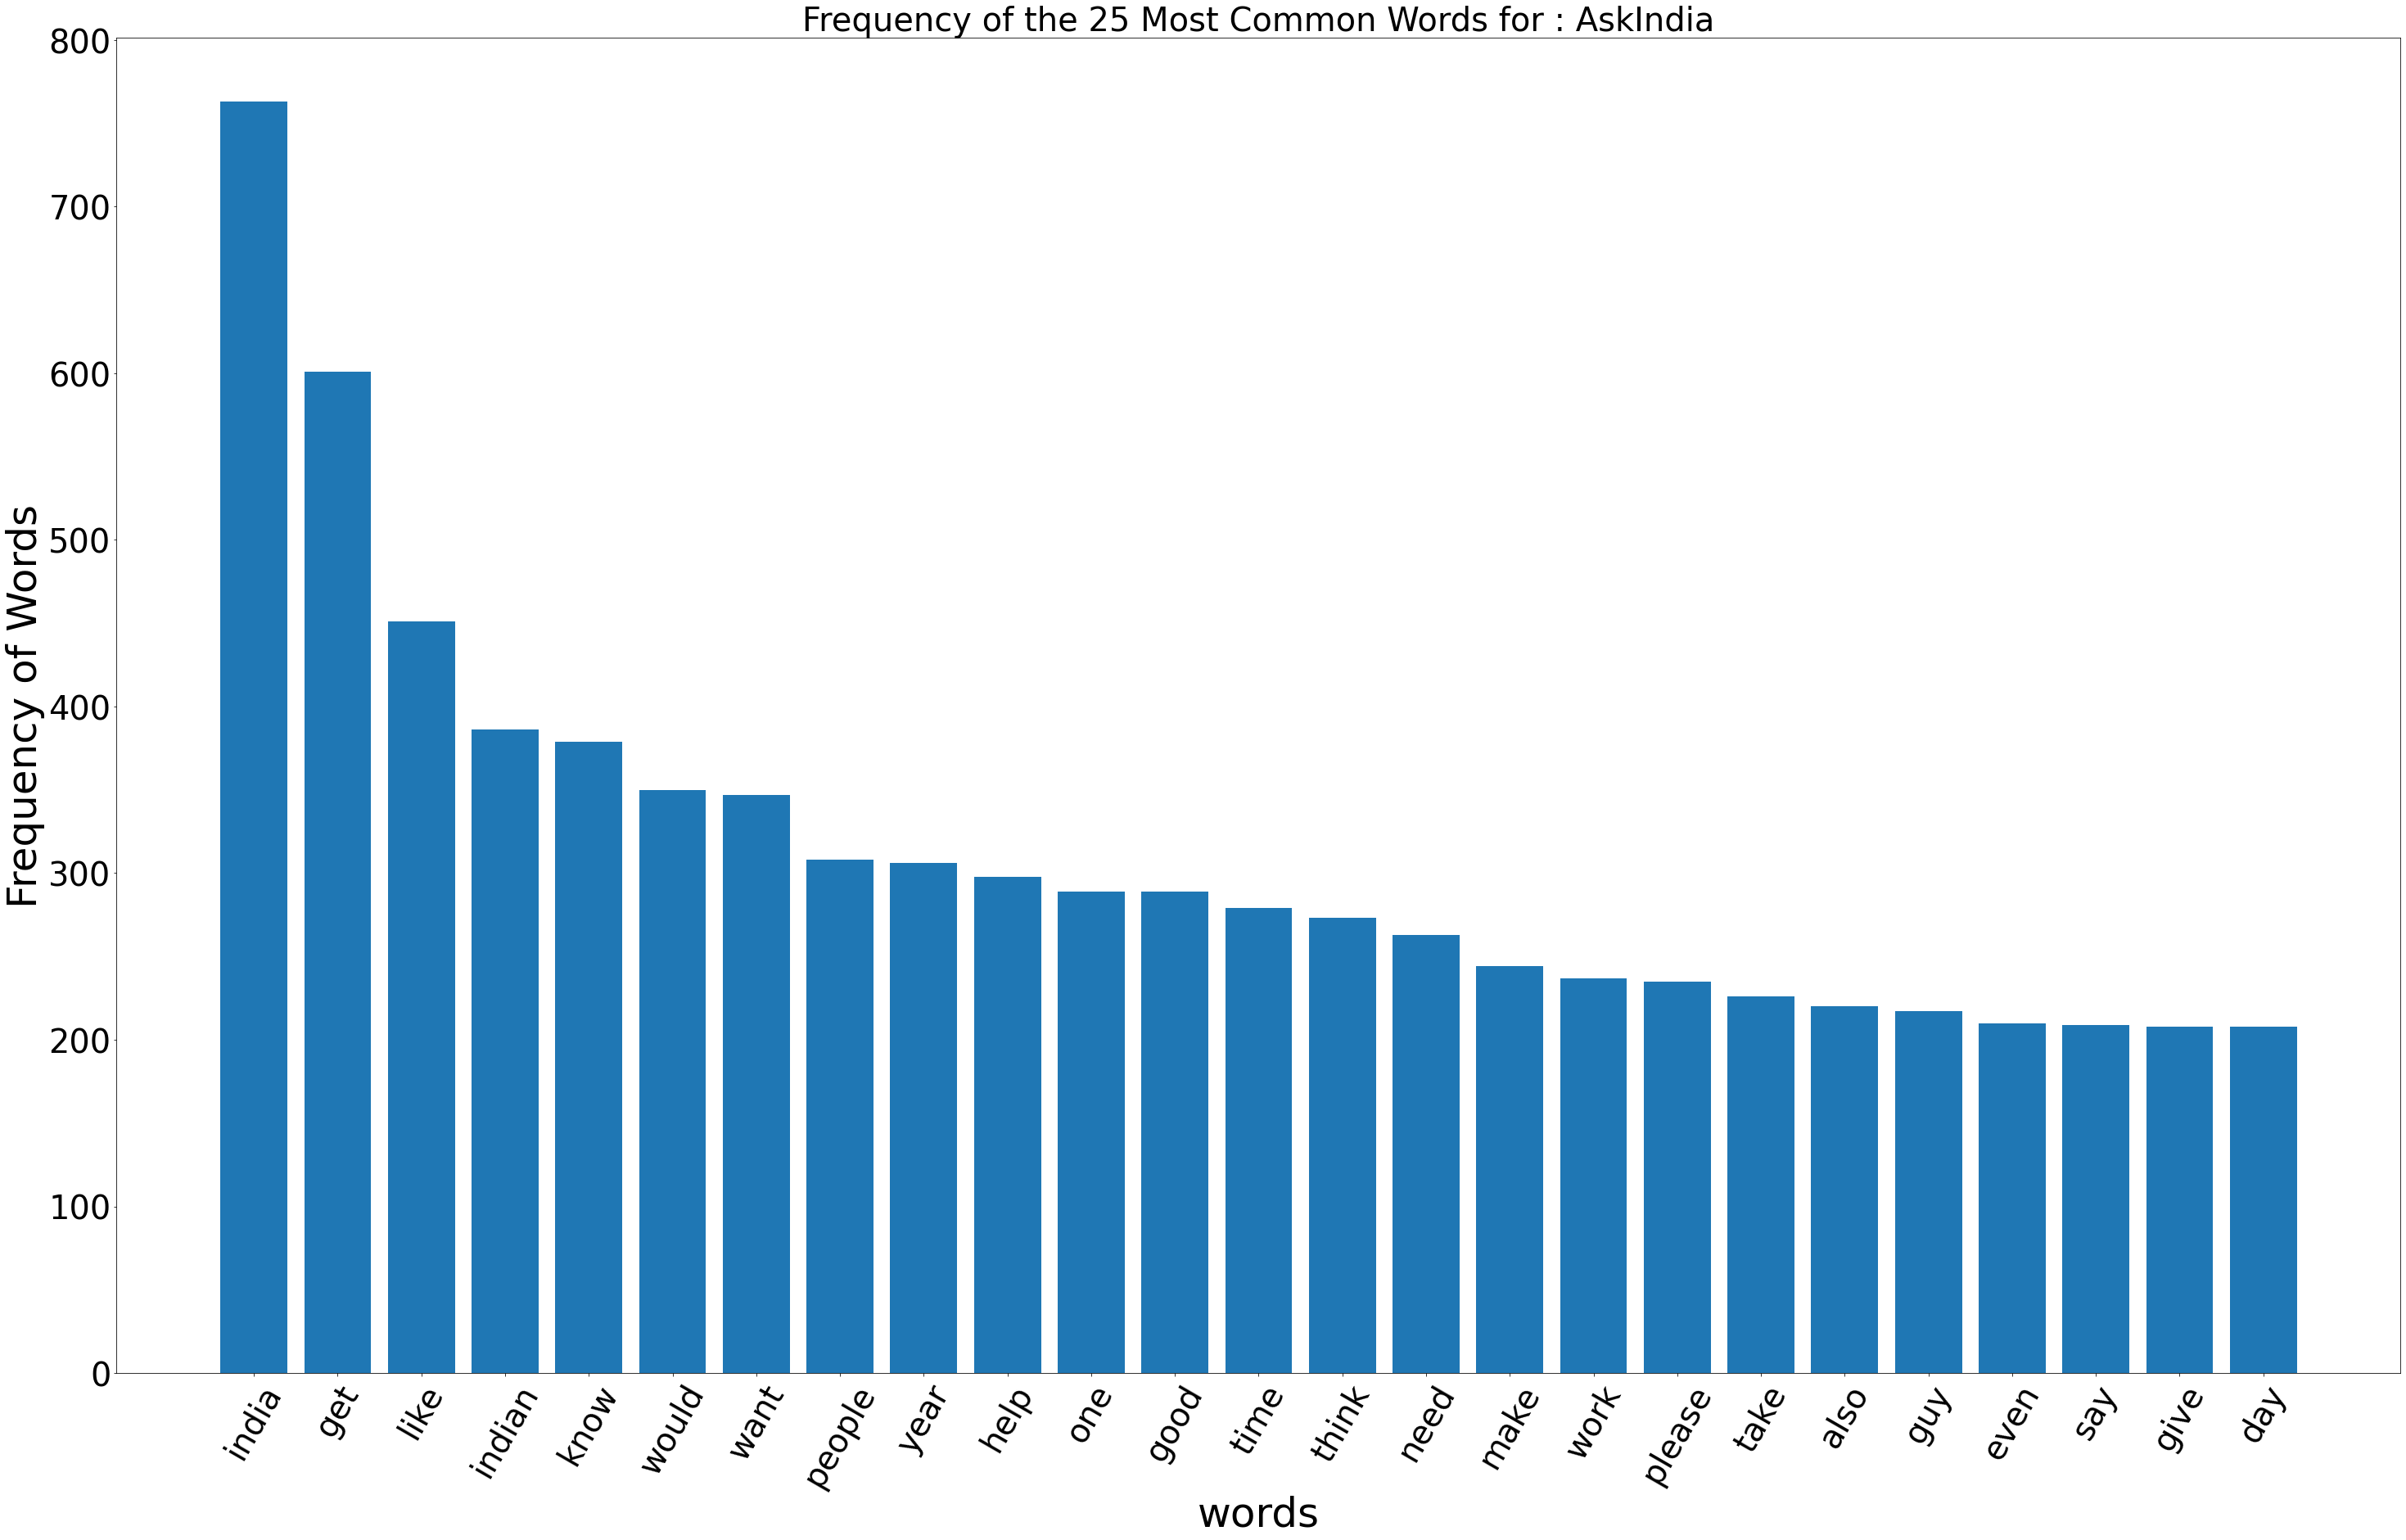

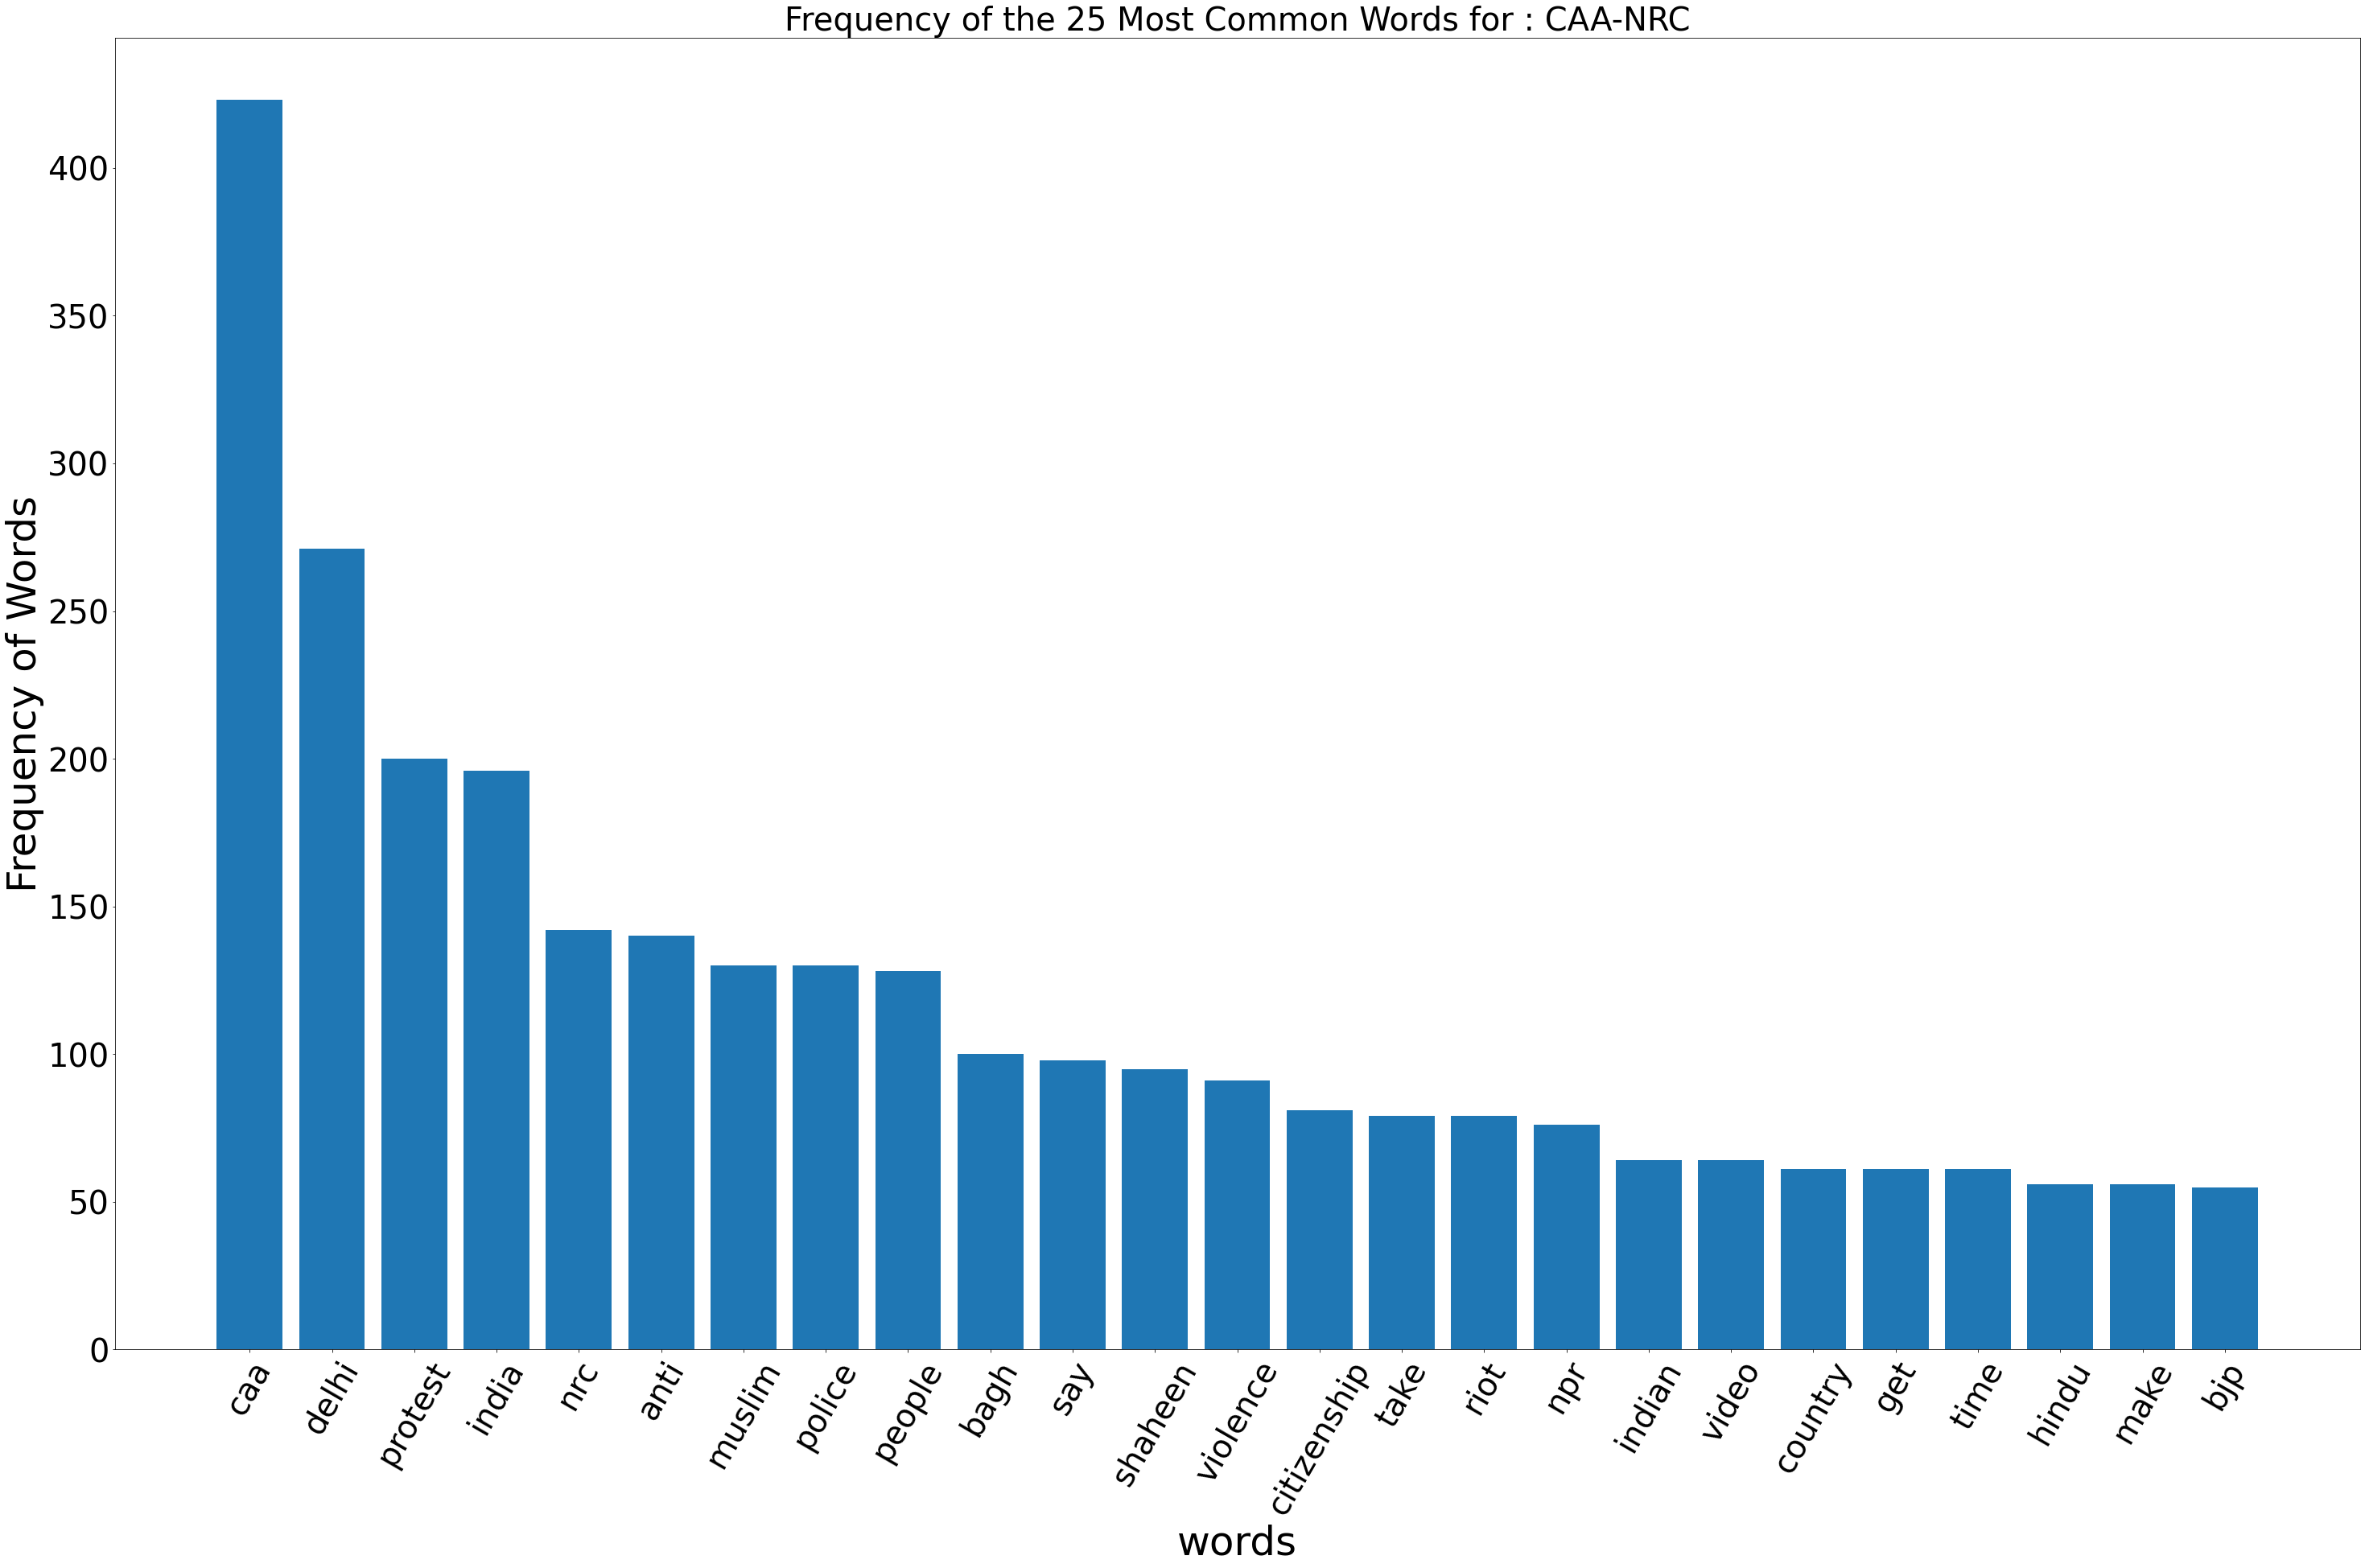

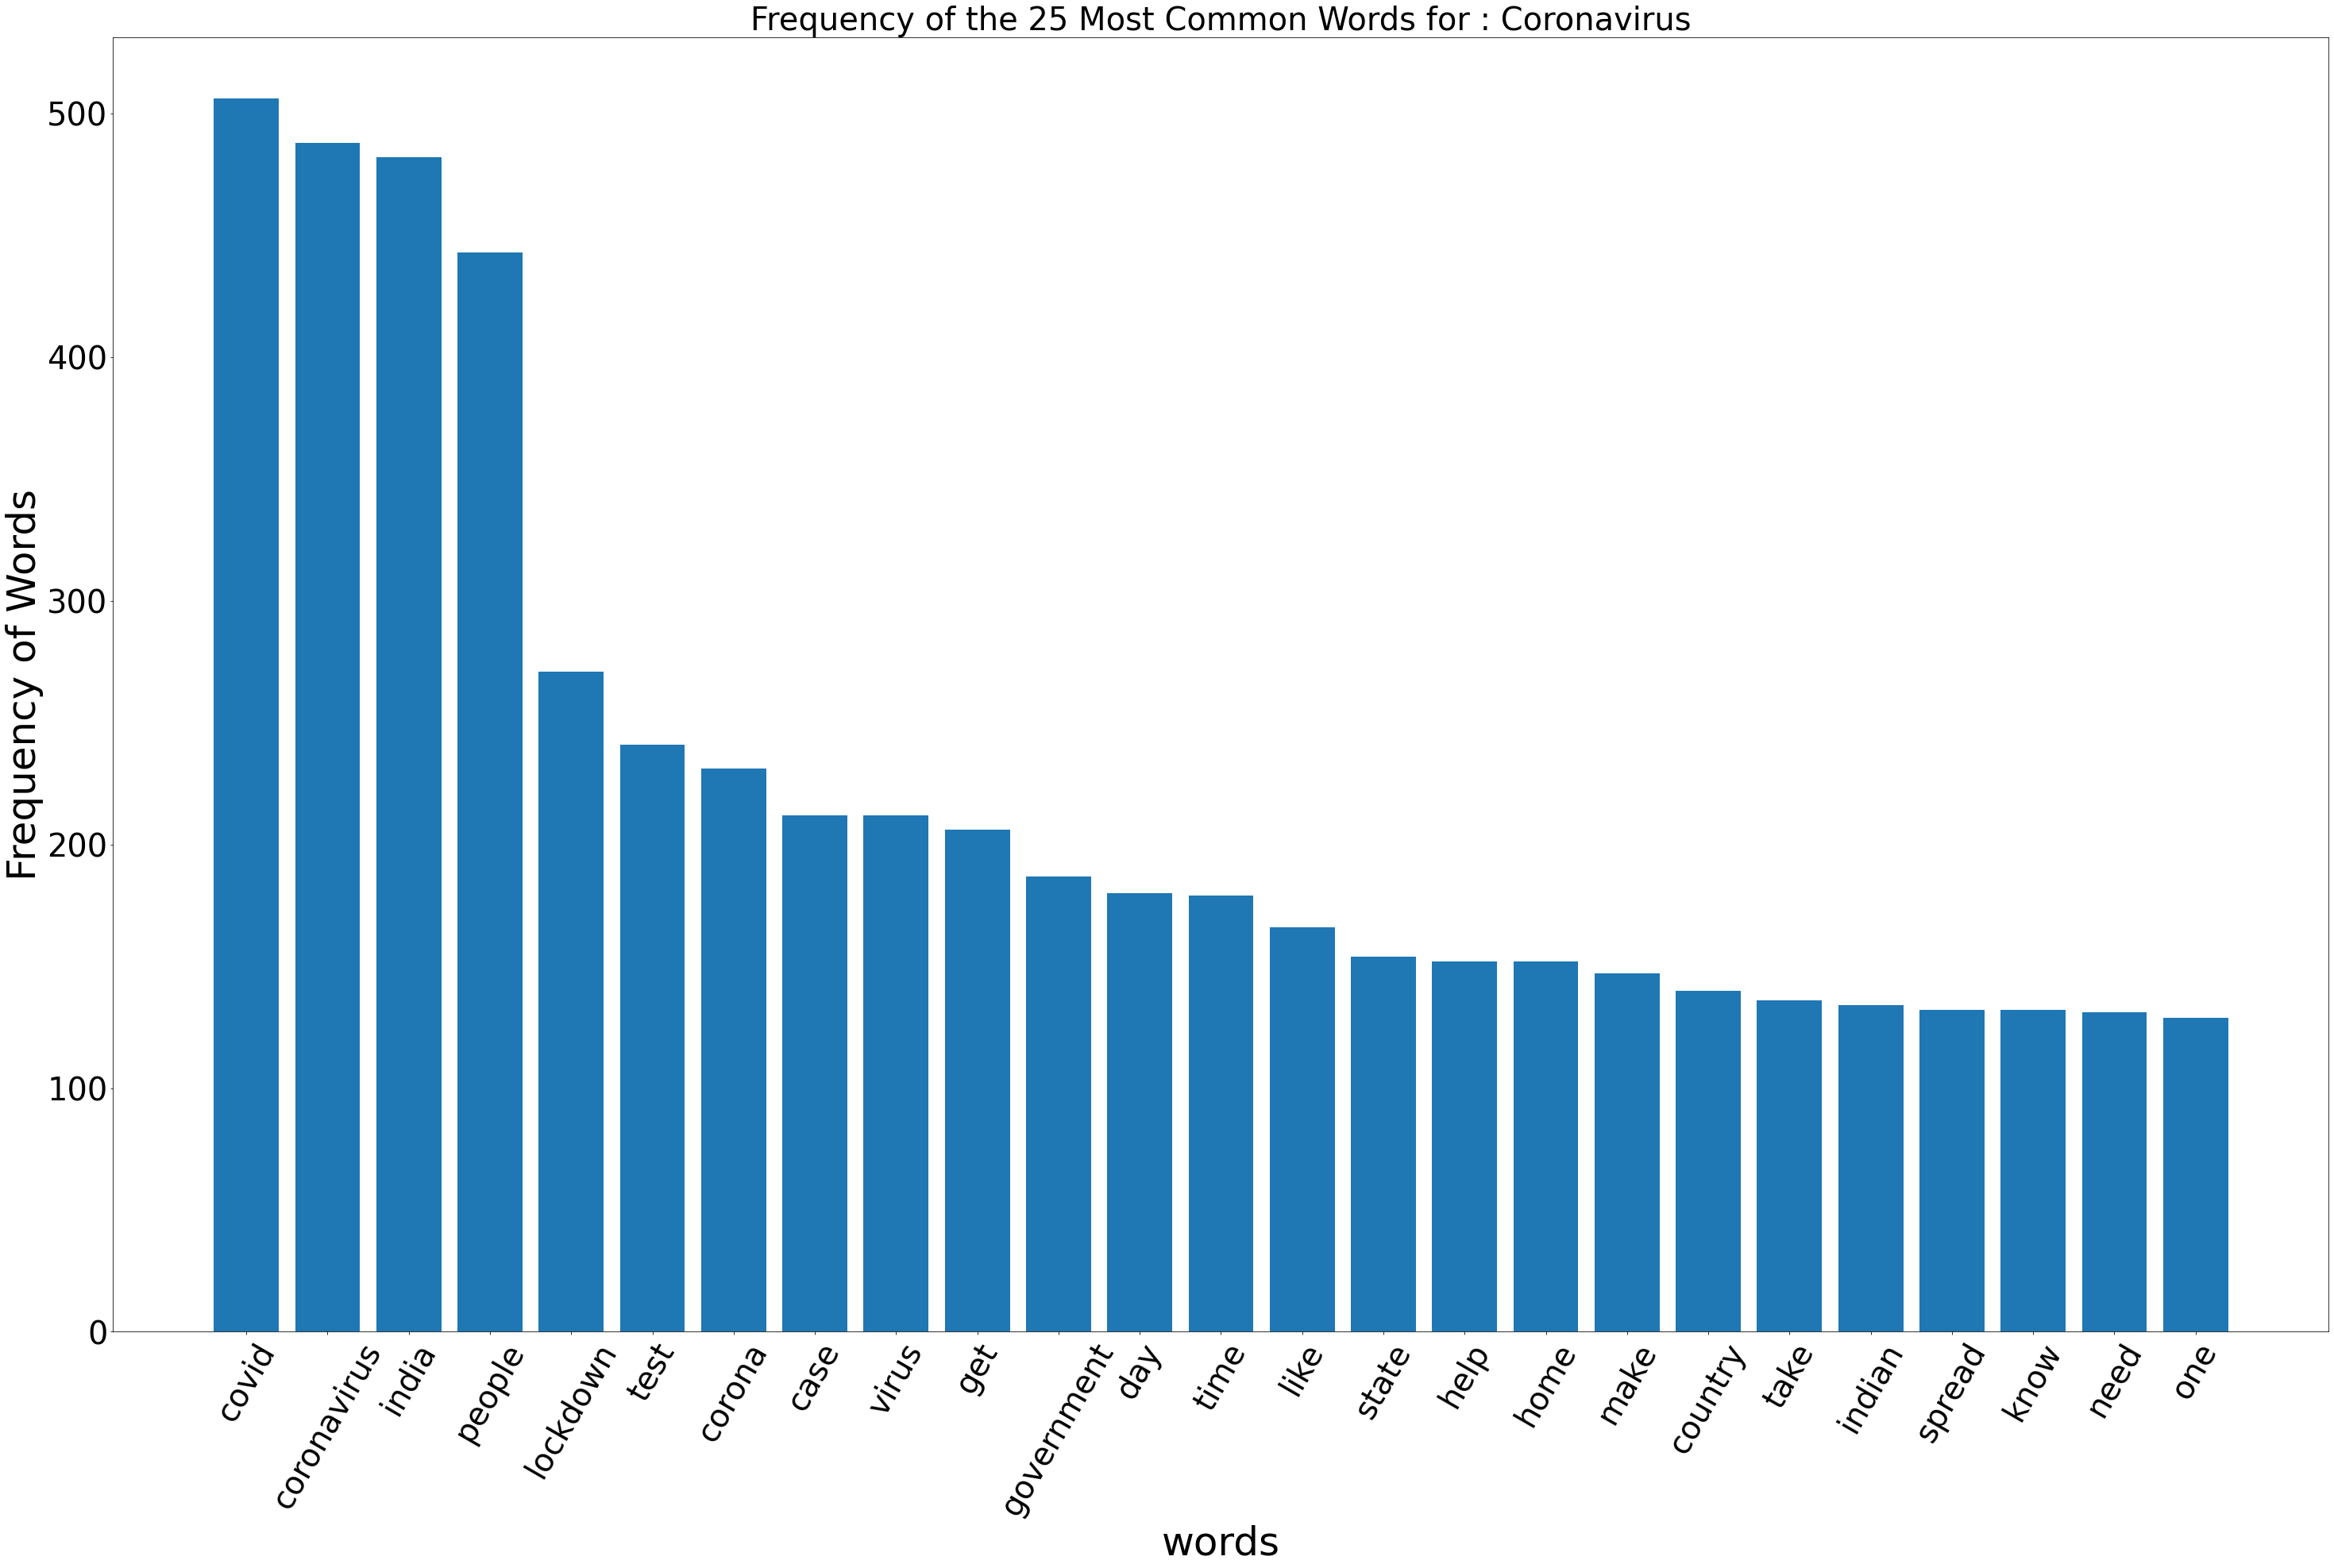

In [15]:
for flair in flairs:
    group = group_by.loc[flair]
    words = list(zip(*group))[0]
    freq = list(zip(*group))[1]

    plt.figure(figsize=(50, 30))
    plt.bar(words, freq)
    plt.xlabel("words", fontsize=50)
    plt.ylabel("Frequency of Words", fontsize=50)
    plt.yticks(fontsize=40)
    plt.xticks(rotation=60, fontsize=40)
    plt.title('Frequency of the 25 Most Common Words for : {}'.format(flair), fontsize=40)
    plt.show()
    

## Topic Modeling

### Latent Dirichlet Allocation (LDA) Topic Modeling

Now that we have prepared our data for topic modeling we’ll be using the Latent Dirichlet Allocation (LDA) approach to determine the topics present in our corpus. In our model, we are going to produce the number topics as the number of flairs. Each topic consists of 10 words. The function will have three required parameters; LDA model, feature names from the document term matrix and the number of words per topic.


### CountVectorizer
The CountVectorizer method of vectorizing tokens converts all the words/tokens into features and then provides a count of occurrence of each word. The end result is called a document term matrix.

In [16]:
tf_vectorizer = CountVectorizer(max_df=0.8, max_features=5000)

In [17]:
tf=tf_vectorizer.fit_transform(data['small_words_rem_str'].values)
tf_feature_names = tf_vectorizer.get_feature_names()

In [18]:
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))
doc_term_matrix

,aadhaar,aadhar,aaj,aap,aarti,aayog,abandon,abdullah,abhijit,abhinandan,...,youth,youtube,youtuber,yuvraj,zealand,zenfone,zero,zomato,zone,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20743,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20744,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20745,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20746,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
lda_model = LatentDirichletAllocation(n_components=len(flairs), learning_method='online', max_iter=100, random_state=0).fit(tf)

In [20]:
num_top_words = 10

def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-num_top_words -1:-1]]))
        
display_topics(lda_model, tf_feature_names, num_top_words)

Topic 0:
india report watch indian last high economy travel check market
Topic 1:
find india post government use company service data student buy
Topic 2:
india world best top live cup corona without mumbai match
Topic 3:
modi coronavirus india government pakistan bjp indian song china water
Topic 4:
delhi state show big bank change system call account card
Topic 5:
home video day due bill man shot crore house child
Topic 6:
caa protest india muslim kashmir nrc anti fight law pradesh
Topic 7:
get know would work want help need like year country
Topic 8:
covid india indian test woman govt cricket lockdown team today
Topic 9:
people like one say even think see look come feel
Topic 10:
news food india case order court indian police hindu experience


From the above descriptions of the topics it's hard to clearly discern them. Although, Topic 9 can be expected to model CAA-NRC related posts

In [21]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model, tf, tf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
7      158.304245  152.859161       1        1  19.373881
9     -154.908630  -15.818744       2        1  14.536272
1     -213.980865  376.240234       3        1  13.940498
0      378.758820 -486.598969       4        1   7.680590
4     -381.861908 -316.007904       5        1   7.399761
10     148.385742  530.916138       6        1   7.355246
2      -51.129013 -527.202759       7        1   6.459751
3      137.890610 -201.229828       8        1   6.052482
6     -511.841278   96.375031       9        1   5.831665
5      509.044678  293.871857      10        1   5.745869
8      518.291443  -99.628937      11        1   5.623985, topic_info=           Term         Freq        Total Category  logprob  loglift
2191      india  5236.000000  5236.000000  Default  30.0000  30.0000
1181      delhi  1006.000000  1006.000000  Default  29.0000  29.0000
3241     people  1665.000000  1665.000000  Default  28.0000  28.0000
4951      world   801.000000   801.000000  Default  27.0000  27.0000
2192     indian  1963.000000  1963.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
402   bangalore   119.119204   203.545714  Topic11  -4.8966   2.3424
1138        day   195.657850  1068.044534  Topic11  -4.4003   1.1809
3090       open   105.076106   251.507836  Topic11  -5.0220   2.0053
3910        say   112.317324  1108.233589  Topic11  -4.9554   0.5889
3736     report   107.297831   500.704147  Topic11  -5.0011   1.3377

[532 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
30        5  0.994600  account
47        3  0.995481   action
64        2  0.988326  address
82        1  0.993184   advice
104       8  0.990688      age
...     ...       ...      ...
4978      2  0.002637     year
4978      4  0.199532     year
4978      8  0.109874     year
4978     11  0.066804     year
4991      9  0.995101  youtube

[687 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 10, 2, 1, 5, 11, 3, 4, 7, 6, 9])

## TF-IDF

In [22]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.80, max_features=5000, use_idf=True)

In [23]:
tfidf = tfidf_vectorizer.fit_transform(data['small_words_rem_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))
doc_term_matrix_tfidf

,aadhaar,aadhar,aaj,aap,aarti,aayog,abandon,abdullah,abhijit,abhinandan,...,youth,youtube,youtuber,yuvraj,zealand,zenfone,zero,zomato,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20743,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20744,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20745,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20746,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
lda_model_tfidf = LatentDirichletAllocation(n_components=len(flairs), learning_method='online', max_iter=100, random_state=0).fit(tfidf)

In [25]:
display_topics(lda_model_tfidf, tfidf_feature_names, num_top_words)

Topic 0:
bagh shaheen pune hindi crisis centre stand village supreme india
Topic 1:
covid list sale system hyderabad whatsapp service mobile tax maharashtra
Topic 2:
india cup world cricket launch match live top machine icc
Topic 3:
pakistan recipe hindu violence ipl goa leader chandrayaan south chandigarh
Topic 4:
corona covid song test bank indian card history india review
Topic 5:
protest kerala shot crore coronavirus karnataka case rape tamil fire
Topic 6:
india indian get people make like say one coronavirus delhi
Topic 7:
pradesh chicken kolkata zomato himachal inside sabha nrc lok manali
Topic 8:
lockdown india delhi china new manufacturer citizenship assam plant rise
Topic 9:
anti modi singh minister kohli gold win dhoni narendra gandhi
Topic 10:
mumbai iphone riot image food view swiggy lake gujarat resolution


In [26]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda_model_tfidf, tfidf, tfidf_vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
6      158.304245  152.859161       1        1  41.685093
1     -154.908630  -15.818744       2        1   8.059998
4     -213.980865  376.240234       3        1   7.037259
0      378.758820 -486.598969       4        1   6.839402
8     -381.861908 -316.007904       5        1   6.801282
2      148.385742  530.916138       6        1   6.371448
9      -51.129013 -527.202759       7        1   5.504939
5      137.890610 -201.229828       8        1   5.057144
10    -511.841278   96.375031       9        1   4.505259
3      509.044678  293.871857      10        1   4.460269
7      518.291443  -99.628937      11        1   3.677908, topic_info=             Term        Freq       Total Category  logprob  loglift
4951        world  147.000000  147.000000  Default  30.0000  30.0000
3163     pakistan  106.000000  106.000000  Default  29.0000  29.0000
2191        india  616.000000  616.000000  Default  28.0000  28.0000
1009  coronavirus  140.000000  140.000000  Default  27.0000  27.0000
1037        covid  136.000000  136.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
713       central   17.151800   22.141289  Topic11  -4.7775   3.0475
3026          nrc   24.423858   64.995511  Topic11  -4.4240   2.3241
4173    somewhere   11.982507   14.867804  Topic11  -5.1362   3.0871
1423     election   14.641062   43.526325  Topic11  -4.9358   2.2133
2692        march   10.878332   35.812555  Topic11  -5.2328   2.1113

[495 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
30        3  0.986391    account
36        8  0.959657     accuse
91        5  0.933430     affect
98       10  0.963403     africa
118       9  0.958212  ahmedabad
...     ...       ...        ...
4978      1  0.769464       year
4978      3  0.176335       year
4978      5  0.048091       year
4994      5  0.971272    zealand
4997     11  0.970285     zomato

[637 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 2, 5, 1, 9, 3, 10, 6, 11, 4, 8])

## Non-Negative Matrix Factorization (NMF)
NMF (Nonnegative Matrix Factorization)  is a matrix factorization method where we constrain the matrices to be nonnegative.
### Using Count Vectorizer features


In [27]:
nmf = NMF(n_components=len(flairs), random_state=0, alpha=.1).fit(tf)
display_topics(nmf, tf_feature_names, num_top_words)

Topic 0:
doctor medical one year college even exam healthcare people bill
Topic 1:
india indian country world trade company pakistan new china economy
Topic 2:
medium social brand platform user people community marketing engage see
Topic 3:
order court website block isps access high file copyright infringement
Topic 4:
get like know time want work would help make year
Topic 5:
covid hand mask people virus cough use person symptom disease
Topic 6:
data protection bill surveillance privacy security make law committee need
Topic 7:
disney hotstar check link remove show platform content beauty monster
Topic 8:
order government internet public state shutdown service issue telecom rule
Topic 9:
people country indian like bjp say even police one think
Topic 10:
update source date coronavirus state case number covid test positive


### Using TF-IDF features

In [28]:
nmf_tfidf = NMF(n_components=len(flairs), random_state=0, alpha=.1).fit(tfidf)
display_topics(nmf_tfidf, tfidf_feature_names, num_top_words)

Topic 0:
india manufacturer pakistan time machine news exporter launch plant growth
Topic 1:
get like people make know one need help think time
Topic 2:
indian economy food team woman chicken american government recipe south
Topic 3:
world cup cricket icc match pakistan team live win score
Topic 4:
delhi caa protest nrc police anti bagh violence shaheen muslim
Topic 5:
best top specialist vashikaran service grotal black hyderabad magic love
Topic 6:
coronavirus covid test case lockdown day positive report fight pandemic
Topic 7:
modi narendra govt minister bjp election say government trump prime
Topic 8:
mumbai shot food today phone year review old technology city
Topic 9:
song new hindi video old bollywood romantic late love remix
Topic 10:
corona virus fight people rap spread stop due safe today


The topics produced via NMF seem to be much more distinct compared to LDA.
From the keywords of some of the topic, we can make guesses to what do these topics direct towards, like,

Topic 3 - Sports

Topic 4 - CAA-NRC

Topic 6 & 10 - Coronavirus

Topic 7 - Politics

Topic 8 - A mixture of Photography and Technology


Other topic seem to a mixture of multiple classes, it may be due to the similar narrative of the posts in different classes. For example a post in AskIndia can literally be regarding anything(such as food, politics, etc.) which may fall under some other similar independent class.



## Chi-square Correlation


In [29]:
label_to_id = {"Business/Finance" : 0,
"Policy/Economy" : 1,
"[R]eddiquette" : 2,
"Food" : 3,
"Science/Technology" : 4,
"Sports" : 5,
"Photography" : 6,
"Politics" : 7,
"AskIndia" : 8,
'CAA-NRC' : 9,
'Coronavirus' : 10,                         
}

id_to_label = {v: k for k, v in label_to_id.items()}

In [30]:
data['flair_id'] = data['flair'].map(label_to_id)

### Count Vectorizer

In [31]:
tf_vectorizer = CountVectorizer(max_df=0.8, max_features=5000, ngram_range=(1,2))
tf=tf_vectorizer.fit_transform(data['small_words_rem_str'].values)
tf_feature_names = tf_vectorizer.get_feature_names()
doc_term_matrix = pd.DataFrame(tf.toarray(), columns=list(tf_feature_names))


In [32]:
N = 5
for flair, flair_id in sorted(label_to_id.items()):
    features_chi2 = chi2(doc_term_matrix, data['flair_id'] == flair_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tf_feature_names)[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(flair))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'AskIndia':
  . Most correlated unigrams:
. know
. like
. would
. want
. get
  . Most correlated bigrams:
. please suggest
. want know
. need help
. thanks advance
. please help
# 'Business/Finance':
  . Most correlated unigrams:
. grotal
. specialist
. corrugation
. machine
. manufacturer
  . Most correlated bigrams:
. corrugation machine
. water meter
. manufacturer exporter
. manufacturer india
. machine manufacturer
# 'CAA-NRC':
  . Most correlated unigrams:
. bagh
. nrc
. shaheen
. protest
. caa
  . Most correlated bigrams:
. delhi riot
. caa protest
. caa nrc
. shaheen bagh
. anti caa
# 'Coronavirus':
  . Most correlated unigrams:
. virus
. corona
. lockdown
. coronavirus
. covid
  . Most correlated bigrams:
. update source
. date update
. covid case
. test positive
. corona virus
# 'Food':
  . Most correlated unigrams:
. curry
. eat
. chicken
. food
. recipe
  . Most correlated bigrams:
. butter chicken
. chicken curry
. peanut butter
. street food
. indian food
# 'Photography

### TF-IDF

In [33]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.2, max_features=5000, use_idf=True)
tfidf = tfidf_vectorizer.fit_transform(data['small_words_rem_str'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))

In [34]:
N = 5
for flair, flair_id in sorted(label_to_id.items()):
    features_chi2 = chi2(doc_term_matrix, data['flair_id'] == flair_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tf_feature_names)[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}':".format(flair))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'AskIndia':
  . Most correlated unigrams:
. know
. like
. would
. want
. get
  . Most correlated bigrams:
. please suggest
. want know
. need help
. thanks advance
. please help
# 'Business/Finance':
  . Most correlated unigrams:
. grotal
. specialist
. corrugation
. machine
. manufacturer
  . Most correlated bigrams:
. corrugation machine
. water meter
. manufacturer exporter
. manufacturer india
. machine manufacturer
# 'CAA-NRC':
  . Most correlated unigrams:
. bagh
. nrc
. shaheen
. protest
. caa
  . Most correlated bigrams:
. delhi riot
. caa protest
. caa nrc
. shaheen bagh
. anti caa
# 'Coronavirus':
  . Most correlated unigrams:
. virus
. corona
. lockdown
. coronavirus
. covid
  . Most correlated bigrams:
. update source
. date update
. covid case
. test positive
. corona virus
# 'Food':
  . Most correlated unigrams:
. curry
. eat
. chicken
. food
. recipe
  . Most correlated bigrams:
. butter chicken
. chicken curry
. peanut butter
. street food
. indian food
# 'Photography

## Saving the file

In [35]:
data.drop(['small_words_rem', 'post_len', 'word_count'], axis = 1, inplace=True) 

In [36]:
data.rename(columns={'small_words_rem_str': 'title'}, inplace=True)

In [37]:
data.to_pickle("data_cleaned_class.pkl")